Topic: Project 3 - Predicting Drug Users  
Subject: Classification Modeling    
Date: 02/12/2020    
Name: Ake Paramadilok  

# Imports

In [1]:
import numpy as np
import pandas as pd
import math
import pickle
from io import StringIO, BytesIO
from collections import defaultdict

# Import custom functions
import Project_03_drugs_function_library as drugslib


# sklearn packages
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import (accuracy_score, precision_score, recall_score, precision_recall_curve, f1_score, 
                            fbeta_score, confusion_matrix, roc_auc_score, roc_curve, make_scorer)
from sklearn.model_selection import (learning_curve, cross_val_score, cross_validate, KFold, StratifiedKFold,
                                    cross_val_predict, train_test_split, GridSearchCV)
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier, BaggingRegressor) 
#                               StackingClassifier
from sklearn.svm import SVC

# statsmodels import
from statsmodels.tools import add_constant
import patsy

# import plotting tools
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Question, Purpose and Research

**Question**   
What is the likelihood that an individual has used illicit drugs based on their Five Factor Model personality traits and demographics?  

**Purpose**  
Findings can be use to direct early interventions and recommend changes in individuals environment to reduce risk.  

**Research**    
Current research indicates:  
High N, E and low C are highly correlated with hazardous health behaviours.

Low C and high socioeconomic status correlated with illicit drug use.

High N and low A and C associated with higher risk of drug use. 

Increasing N and O increases risk of drug use

Increasing C and A decreases risk of drug use. 

Sensation seeking is high for recreational drug users.

Early adolescent onsent of use is robust predictor of future use disorders.

Results are from Revised NEO Five-Factor Inventory (NEO-FFI-R, 60 q), Barratt Impulsiveness Scale v11 (BIS-11, 30 Q) and Impulsivity Sensation-Seeking scale (ImpSS, 19 T/F)

Data collected by Elaine Fehrman via annonymous online survey (2051, 1885 kept) respondents (March 2011-12).  University of Leicester, England

Data biased vs. normal population.

**Definitions of Personality Traits**  
1. Neuroticism (N) is a long-term tendency to experience negative emotions such
as nervousness, tension, anxiety and depression;
2. Extraversion (E) is manifested in outgoing, warm, active, assertive, talkative,
cheerful, and in search of stimulation characteristics;
3. Openness to experience (O) is a general appreciation for art, unusual ideas, and
imaginative, creative, unconventional, and wide interests,
4. Agreeableness (A) is a dimension of interpersonal relations, characterized by
altruism, trust, modesty, kindness, compassion and cooperativeness;
5. Conscientiousness (C) is a tendency to be organized and dependable,
strong-willed, persistent, reliable, and efficient.

# Data Acquisition

## Load Data

Primary dataset was acquired from UCI Machine Learning Database.  Link below.  
https://archive.ics.uci.edu/ml/datasets/Drug+consumption+%28quantified%29  

See Project_03_Web_Scraping.ipynb for auxilary data sources. 

In [9]:
f = open("drug_consumption.data", "r")

In [10]:
df = pd.read_csv('drug_consumption.data', header=None).reset_index(drop=True)

In [11]:
dvrc_df = pd.read_csv('divorce_df.csv').reset_index(drop=True)

In [12]:
edu_df = pd.read_csv('edu_exp_df.csv', index_col = 0)

In [13]:
gdp_df = pd.read_csv('gdp_df.csv', index_col = 0)

In [14]:
life_df = pd.read_csv('life_exp_df.csv', index_col = 0)

In [15]:
tertedu_df = pd.read_csv('tert_edu_df.csv', index_col = 0)

## Clean Data

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1885 entries, 0 to 1884
Data columns (total 32 columns):
0     1885 non-null int64
1     1885 non-null float64
2     1885 non-null float64
3     1885 non-null float64
4     1885 non-null float64
5     1885 non-null float64
6     1885 non-null float64
7     1885 non-null float64
8     1885 non-null float64
9     1885 non-null float64
10    1885 non-null float64
11    1885 non-null float64
12    1885 non-null float64
13    1885 non-null object
14    1885 non-null object
15    1885 non-null object
16    1885 non-null object
17    1885 non-null object
18    1885 non-null object
19    1885 non-null object
20    1885 non-null object
21    1885 non-null object
22    1885 non-null object
23    1885 non-null object
24    1885 non-null object
25    1885 non-null object
26    1885 non-null object
27    1885 non-null object
28    1885 non-null object
29    1885 non-null object
30    1885 non-null object
31    1885 non-null object
dtypes: float64(12

### Drop NaNs

In [17]:
df.dropna(how='all')

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,1,0.49788,0.48246,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,...,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL2,CL0,CL0
1,2,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,...,CL4,CL0,CL2,CL0,CL2,CL3,CL0,CL4,CL0,CL0
2,3,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,...,CL0,CL0,CL0,CL0,CL0,CL0,CL1,CL0,CL0,CL0
3,4,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,...,CL0,CL0,CL2,CL0,CL0,CL0,CL0,CL2,CL0,CL0
4,5,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,...,CL1,CL0,CL0,CL1,CL0,CL0,CL2,CL2,CL0,CL0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1880,1884,-0.95197,0.48246,-0.61113,-0.57009,-0.31685,-1.19430,1.74091,1.88511,0.76096,...,CL0,CL0,CL0,CL3,CL3,CL0,CL0,CL0,CL0,CL5
1881,1885,-0.95197,-0.48246,-0.61113,-0.57009,-0.31685,-0.24649,1.74091,0.58331,0.76096,...,CL2,CL0,CL0,CL3,CL5,CL4,CL4,CL5,CL0,CL0
1882,1886,-0.07854,0.48246,0.45468,-0.57009,-0.31685,1.13281,-1.37639,-1.27553,-1.77200,...,CL4,CL0,CL2,CL0,CL2,CL0,CL2,CL6,CL0,CL0
1883,1887,-0.95197,0.48246,-0.61113,-0.57009,-0.31685,0.91093,-1.92173,0.29338,-1.62090,...,CL3,CL0,CL0,CL3,CL3,CL0,CL3,CL4,CL0,CL0


### Drop Index

In [18]:
df = df.drop(columns = 0).reset_index(drop = True)
df

,1,2,3,4,5,6,7,8,9,10,...,22,23,24,25,26,27,28,29,30,31
0,0.49788,0.48246,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,...,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL2,CL0,CL0
1,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,-0.14277,...,CL4,CL0,CL2,CL0,CL2,CL3,CL0,CL4,CL0,CL0
2,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,...,CL0,CL0,CL0,CL0,CL0,CL0,CL1,CL0,CL0,CL0
3,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,0.58489,...,CL0,CL0,CL2,CL0,CL0,CL0,CL0,CL2,CL0,CL0
4,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,1.30612,...,CL1,CL0,CL0,CL1,CL0,CL0,CL2,CL2,CL0,CL0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1880,-0.95197,0.48246,-0.61113,-0.57009,-0.31685,-1.19430,1.74091,1.88511,0.76096,-1.13788,...,CL0,CL0,CL0,CL3,CL3,CL0,CL0,CL0,CL0,CL5
1881,-0.95197,-0.48246,-0.61113,-0.57009,-0.31685,-0.24649,1.74091,0.58331,0.76096,-1.51840,...,CL2,CL0,CL0,CL3,CL5,CL4,CL4,CL5,CL0,CL0
1882,-0.07854,0.48246,0.45468,-0.57009,-0.31685,1.13281,-1.37639,-1.27553,-1.77200,-1.38502,...,CL4,CL0,CL2,CL0,CL2,CL0,CL2,CL6,CL0,CL0
1883,-0.95197,0.48246,-0.61113,-0.57009,-0.31685,0.91093,-1.92173,0.29338,-1.62090,-2.57309,...,CL3,CL0,CL0,CL3,CL3,CL0,CL3,CL4,CL0,CL0


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1885 entries, 0 to 1884
Data columns (total 31 columns):
1     1885 non-null float64
2     1885 non-null float64
3     1885 non-null float64
4     1885 non-null float64
5     1885 non-null float64
6     1885 non-null float64
7     1885 non-null float64
8     1885 non-null float64
9     1885 non-null float64
10    1885 non-null float64
11    1885 non-null float64
12    1885 non-null float64
13    1885 non-null object
14    1885 non-null object
15    1885 non-null object
16    1885 non-null object
17    1885 non-null object
18    1885 non-null object
19    1885 non-null object
20    1885 non-null object
21    1885 non-null object
22    1885 non-null object
23    1885 non-null object
24    1885 non-null object
25    1885 non-null object
26    1885 non-null object
27    1885 non-null object
28    1885 non-null object
29    1885 non-null object
30    1885 non-null object
31    1885 non-null object
dtypes: float64(12), object(19)
memory usage

### Rename Columns

Columns named according to the information provided by the data set creators: https://archive.ics.uci.edu/ml/datasets/Drug+consumption+%28quantified%29

In [20]:
# Create list of column names in order
col_name_values = [
    'age',
    'gender',
    'education_level',
    'country',
    'ethnicity',
    'neuroticism',
    'extraversion',
    'openness_to_experience',
    'agreeableness',
    'conscientiousness',
    'impulsivity',
    'sensation_seeking',
    'alcohol',
    'amphetamines',
    'amyl_nitrite',
    'benxodiazepine',
    'caffeine',
    'cannabis',
    'chocolate',
    'cocaine',
    'crack',
    'ecstacy',
    'heroin',
    'ketamine',
    'legal_highs',
    'LSD',
    'methadone',
    'mushrooms',
    'nicotine',
    'Semeron(placebo)',
    'volatile_substance_abuse',
]

In [21]:
# Create a dictionary with current and new column names as keys and values respectively. 
col_name = {k:v for k,v in zip(range(1,len(col_name_values)+1),col_name_values)}
col_name

{1: 'age',
 2: 'gender',
 3: 'education_level',
 4: 'country',
 5: 'ethnicity',
 6: 'neuroticism',
 7: 'extraversion',
 8: 'openness_to_experience',
 9: 'agreeableness',
 10: 'conscientiousness',
 11: 'impulsivity',
 12: 'sensation_seeking',
 13: 'alcohol',
 14: 'amphetamines',
 15: 'amyl_nitrite',
 16: 'benxodiazepine',
 17: 'caffeine',
 18: 'cannabis',
 19: 'chocolate',
 20: 'cocaine',
 21: 'crack',
 22: 'ecstacy',
 23: 'heroin',
 24: 'ketamine',
 25: 'legal_highs',
 26: 'LSD',
 27: 'methadone',
 28: 'mushrooms',
 29: 'nicotine',
 30: 'Semeron(placebo)',
 31: 'volatile_substance_abuse'}

In [22]:
# Rename columns
df = df.rename(col_name, axis=1).reset_index(drop= True)

In [23]:
# Check columns
df.describe()

,age,gender,education_level,country,ethnicity,neuroticism,extraversion,openness_to_experience,agreeableness,conscientiousness,impulsivity,sensation_seeking
count,1885.00000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000
mean,0.03461,-0.000256,-0.003806,0.355542,-0.309577,0.000047,-0.000163,-0.000534,-0.000245,-0.000386,0.007216,-0.003292
std,0.87836,0.482588,0.950078,0.700335,0.166226,0.998106,0.997448,0.996229,0.997440,0.997523,0.954435,0.963701
min,-0.95197,-0.482460,-2.435910,-0.570090,-1.107020,-3.464360,-3.273930,-3.273930,-3.464360,-3.464360,-2.555240,-2.078480
25%,-0.95197,-0.482460,-0.611130,-0.570090,-0.316850,-0.678250,-0.695090,-0.717270,-0.606330,-0.652530,-0.711260,-0.525930
50%,-0.07854,-0.482460,-0.059210,0.960820,-0.316850,0.042570,0.003320,-0.019280,-0.017290,-0.006650,-0.217120,0.079870
75%,0.49788,0.482460,0.454680,0.960820,-0.316850,0.629670,0.637790,0.723300,0.760960,0.584890,0.529750,0.765400
max,2.59171,0.482460,1.984370,0.960820,1.907250,3.273930,3.273930,2.901610,3.464360,3.464360,2.901610,1.921730


## Un-standardizing Demographic Data

### Replace Age

Ages will be represented by numbers as follows:  

18-24 years old = 18  
25-34 years old = 25  
35-44 years old = 35  
45-54 years old = 45  
55-65 years old = 55  
65+ years old   = 65  

In [24]:
# Check the unique values 
df.age.unique()

array([ 0.49788, -0.07854, -0.95197,  2.59171,  1.09449,  1.82213])

In [25]:
# Define replacement dictionary
# 

age_dict = {0.49788000000000004:35, # extra digits added after checking unique values after running the function 1x
            -0.07854:25, 
            -0.9519700000000001:18,  
            2.59171:65,  
            1.09449:45,  
            1.82213:55}

In [26]:
# Replace quantified age data with categorical data
drugslib.replace_values(df, 'age', age_dict)

In [27]:
# Verify change
df.head()

,age,gender,education_level,country,ethnicity,neuroticism,extraversion,openness_to_experience,agreeableness,conscientiousness,...,ecstacy,heroin,ketamine,legal_highs,LSD,methadone,mushrooms,nicotine,Semeron(placebo),volatile_substance_abuse
0,35.0,0.48246,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,...,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL2,CL0,CL0
1,25.0,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,-0.14277,...,CL4,CL0,CL2,CL0,CL2,CL3,CL0,CL4,CL0,CL0
2,35.0,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,...,CL0,CL0,CL0,CL0,CL0,CL0,CL1,CL0,CL0,CL0
3,18.0,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,0.58489,...,CL0,CL0,CL2,CL0,CL0,CL0,CL0,CL2,CL0,CL0
4,35.0,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,1.30612,...,CL1,CL0,CL0,CL1,CL0,CL0,CL2,CL2,CL0,CL0


In [28]:
# Verify change
df.age.unique()

array([35., 25., 18., 65., 45., 55.])

### Replace Educational Level

Educational level will be represented as follows:  
  
Left before 16 yrs = 15      
    Left at 16 yrs = 16      
    Left at 17 yrs = 17       
    Left at 18 yrs = 18    
Some college or university, no certificate or degree = 19    
Professional certificate/diploma = 20    
University degree = 21    
Masters degree = 23    
Doctorate degree = 27    

In [29]:
# Check the unique values 
df.education_level.unique()

array([-0.05921,  1.98437,  1.16365, -1.22751, -1.7379 ,  0.45468,
       -0.61113, -2.43591, -1.43719])

In [30]:
# Define replacement dictionary
edu_dict = {
    -2.43591:15,
    -1.7379:16,
    -1.43719:17,
    -1.22751:18,
    -0.6111300000000001:19,
    -0.059210000000000006:20,
    0.45468000000000003:21,
    1.16365:23,
    1.98437:27
}

In [31]:
# Replace quantified age data with categorical data
drugslib.replace_values(df, 'education_level', edu_dict)

In [32]:
# Verify change
df.education_level.unique()

array([20., 27., 23., 18., 16., 21., 19., 15., 17.])

### Replace Gender

In [33]:
# Check the unique values 
df.gender.unique()

array([ 0.48246, -0.48246])

In [34]:
# Define replacement dictionary
# unique values referenced directly because entering in values was not successful
# Female = 0
# Male  = 1
gender_dict = {df.gender.unique()[0]:0, df.gender.unique()[1]:1}

In [35]:
# Replace quantified age data with categorical data
drugslib.replace_values(df, 'gender', gender_dict)

In [36]:
# Verify change
df.gender

0       0.0
1       1.0
2       1.0
3       0.0
4       0.0
       ... 
1880    0.0
1881    1.0
1882    0.0
1883    0.0
1884    1.0
Name: gender, Length: 1885, dtype: float64

### Replace Country of Residence

In [37]:
# Check the unique values 
df['country'].unique()

array([ 0.96082,  0.24923, -0.57009, -0.28519, -0.09765,  0.21128,
       -0.46841])

In [38]:
# Define replacement dictionary
# unique values referenced directly because entering in values was not successful
country_dict = {
    df['country'].unique()[0]:'United Kingdom',
    df['country'].unique()[1]:'Canada',
    df['country'].unique()[2]:'United States',
    df['country'].unique()[3]:'Other',
    df['country'].unique()[4]:'Australia',
    df['country'].unique()[5]:'Ireland',
    df['country'].unique()[6]:'New Zealand'
}

In [39]:
# Replace quantified age data with categorical data
drugslib.replace_values(df, 'country', country_dict)

In [40]:
# Verify change
df['country'].unique()

array(['United Kingdom', 'Canada', 'United States', 'Other', 'Australia',
       'Ireland', 'New Zealand'], dtype=object)

### Replace Ethnicity

In [41]:
# Check the unique values 
df.ethnicity.unique()

array([ 0.126  , -0.31685,  0.1144 , -0.22166, -0.50212, -1.10702,
        1.90725])

In [42]:
# Define replacement dictionary
ethnic_dict = {
    df.ethnicity.unique()[0]:'Mixed-White/Asian', 
    df.ethnicity.unique()[1]:'White', 
    df.ethnicity.unique()[2]:'Other',
    df.ethnicity.unique()[3]:'Mixed-Black/White',
    df.ethnicity.unique()[4]:'Asian',
    df.ethnicity.unique()[5]:'Black',
    df.ethnicity.unique()[6]:'Mixed-Black/Asian'
}

In [43]:
# Replace quantified age data with categorical data
drugslib.replace_values(df, 'ethnicity', ethnic_dict)

In [44]:
# Verify change
df.ethnicity.unique()

array(['Mixed-White/Asian', 'White', 'Other', 'Mixed-Black/White',
       'Asian', 'Black', 'Mixed-Black/Asian'], dtype=object)

## Merge in Other Tables

In [45]:
df.head()

,age,gender,education_level,country,ethnicity,neuroticism,extraversion,openness_to_experience,agreeableness,conscientiousness,...,ecstacy,heroin,ketamine,legal_highs,LSD,methadone,mushrooms,nicotine,Semeron(placebo),volatile_substance_abuse
0,35.0,0.0,20.0,United Kingdom,Mixed-White/Asian,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,...,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL2,CL0,CL0
1,25.0,1.0,27.0,United Kingdom,White,-0.67825,1.93886,1.43533,0.76096,-0.14277,...,CL4,CL0,CL2,CL0,CL2,CL3,CL0,CL4,CL0,CL0
2,35.0,1.0,20.0,United Kingdom,White,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,...,CL0,CL0,CL0,CL0,CL0,CL0,CL1,CL0,CL0,CL0
3,18.0,0.0,23.0,United Kingdom,White,-0.14882,-0.80615,-0.01928,0.59042,0.58489,...,CL0,CL0,CL2,CL0,CL0,CL0,CL0,CL2,CL0,CL0
4,35.0,0.0,27.0,United Kingdom,White,0.73545,-1.63340,-0.45174,-0.30172,1.30612,...,CL1,CL0,CL0,CL1,CL0,CL0,CL2,CL2,CL0,CL0


### Merge Divorce Data

In [46]:
dvrc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 4 columns):
Unnamed: 0      105 non-null int64
country         105 non-null object
continent       102 non-null object
divorce_rate    102 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.4+ KB


In [47]:
df = pd.merge(df, dvrc_df[['country', 'continent','divorce_rate']], how='left', on=['country'])
df

,age,gender,education_level,country,ethnicity,neuroticism,extraversion,openness_to_experience,agreeableness,conscientiousness,...,ketamine,legal_highs,LSD,methadone,mushrooms,nicotine,Semeron(placebo),volatile_substance_abuse,continent,divorce_rate
0,35.0,0.0,20.0,United Kingdom,Mixed-White/Asian,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,...,CL0,CL0,CL0,CL0,CL0,CL2,CL0,CL0,Europe,40.91
1,25.0,1.0,27.0,United Kingdom,White,-0.67825,1.93886,1.43533,0.76096,-0.14277,...,CL2,CL0,CL2,CL3,CL0,CL4,CL0,CL0,Europe,40.91
2,35.0,1.0,20.0,United Kingdom,White,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,...,CL0,CL0,CL0,CL0,CL1,CL0,CL0,CL0,Europe,40.91
3,18.0,0.0,23.0,United Kingdom,White,-0.14882,-0.80615,-0.01928,0.59042,0.58489,...,CL2,CL0,CL0,CL0,CL0,CL2,CL0,CL0,Europe,40.91
4,35.0,0.0,27.0,United Kingdom,White,0.73545,-1.63340,-0.45174,-0.30172,1.30612,...,CL0,CL1,CL0,CL0,CL2,CL2,CL0,CL0,Europe,40.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1880,18.0,0.0,19.0,United States,White,-1.19430,1.74091,1.88511,0.76096,-1.13788,...,CL0,CL3,CL3,CL0,CL0,CL0,CL0,CL5,North America,42.03
1881,18.0,1.0,19.0,United States,White,-0.24649,1.74091,0.58331,0.76096,-1.51840,...,CL0,CL3,CL5,CL4,CL4,CL5,CL0,CL0,North America,42.03
1882,25.0,0.0,21.0,United States,White,1.13281,-1.37639,-1.27553,-1.77200,-1.38502,...,CL2,CL0,CL2,CL0,CL2,CL6,CL0,CL0,North America,42.03
1883,18.0,0.0,19.0,United States,White,0.91093,-1.92173,0.29338,-1.62090,-2.57309,...,CL0,CL3,CL3,CL0,CL3,CL4,CL0,CL0,North America,42.03


In [48]:
df.divorce_rate.describe()

count    1767.000000
mean       41.385020
std         3.214397
min        14.890000
25%        40.910000
50%        40.910000
75%        42.030000
max        47.730000
Name: divorce_rate, dtype: float64

### Merge Edu Expectation Data

In [49]:
edu_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 188 entries, 0 to 187
Data columns (total 4 columns):
country      188 non-null object
continent    188 non-null object
exp_yr       188 non-null float64
mean_yr      188 non-null float64
dtypes: float64(2), object(2)
memory usage: 7.3+ KB


In [50]:
edu_df.rename(columns = {'exp_yr':'edu_exp_yr', 'mean_yr':'edu_mean_yr'}, inplace = True)
edu_df

,country,continent,edu_exp_yr,edu_mean_yr
0,Australia,Oceania,20.4,13.2
1,Denmark,Europe,19.2,12.7
2,New Zealand,Oceania,19.2,12.5
3,Norway,Europe,17.7,12.7
4,Germany,Europe,17.1,13.2
...,...,...,...,...
183,South Sudan,Africa,4.9,4.8
184,Chad,Africa,7.3,2.3
185,Eritrea,Africa,5.0,3.9
186,Burkina Faso,Africa,7.7,1.4


In [51]:
df = pd.merge(df, edu_df[['country', 'edu_exp_yr','edu_mean_yr']], how='left', on=['country'])
df

,age,gender,education_level,country,ethnicity,neuroticism,extraversion,openness_to_experience,agreeableness,conscientiousness,...,LSD,methadone,mushrooms,nicotine,Semeron(placebo),volatile_substance_abuse,continent,divorce_rate,edu_exp_yr,edu_mean_yr
0,35.0,0.0,20.0,United Kingdom,Mixed-White/Asian,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,...,CL0,CL0,CL0,CL2,CL0,CL0,Europe,40.91,16.3,13.3
1,25.0,1.0,27.0,United Kingdom,White,-0.67825,1.93886,1.43533,0.76096,-0.14277,...,CL2,CL3,CL0,CL4,CL0,CL0,Europe,40.91,16.3,13.3
2,35.0,1.0,20.0,United Kingdom,White,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,...,CL0,CL0,CL1,CL0,CL0,CL0,Europe,40.91,16.3,13.3
3,18.0,0.0,23.0,United Kingdom,White,-0.14882,-0.80615,-0.01928,0.59042,0.58489,...,CL0,CL0,CL0,CL2,CL0,CL0,Europe,40.91,16.3,13.3
4,35.0,0.0,27.0,United Kingdom,White,0.73545,-1.63340,-0.45174,-0.30172,1.30612,...,CL0,CL0,CL2,CL2,CL0,CL0,Europe,40.91,16.3,13.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1880,18.0,0.0,19.0,United States,White,-1.19430,1.74091,1.88511,0.76096,-1.13788,...,CL3,CL0,CL0,CL0,CL0,CL5,North America,42.03,16.5,13.2
1881,18.0,1.0,19.0,United States,White,-0.24649,1.74091,0.58331,0.76096,-1.51840,...,CL5,CL4,CL4,CL5,CL0,CL0,North America,42.03,16.5,13.2
1882,25.0,0.0,21.0,United States,White,1.13281,-1.37639,-1.27553,-1.77200,-1.38502,...,CL2,CL0,CL2,CL6,CL0,CL0,North America,42.03,16.5,13.2
1883,18.0,0.0,19.0,United States,White,0.91093,-1.92173,0.29338,-1.62090,-2.57309,...,CL3,CL0,CL3,CL4,CL0,CL0,North America,42.03,16.5,13.2


### Merge GDP Data

In [52]:
gdp_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 189 entries, 0 to 188
Data columns (total 2 columns):
country    189 non-null object
gdppc      189 non-null object
dtypes: object(2)
memory usage: 4.4+ KB


In [53]:
gdp_df.rename(columns = {'gdppc':'gdp_pc'}, inplace = True)
gdp_df

,country,gdp_pc
0,Qatar,"61,264"
1,Macao,"80,890"
2,Luxembourg,"105,280"
3,Singapore,"56,746"
4,Brunei,"28,572"
...,...,...
184,American Samoa,"11,399"
185,Andorra,"39,128"
186,Guam,"35,665"
187,Cuba,"8,541"


In [54]:
gdp_df.gdp_pc = gdp_df.gdp_pc.apply(lambda x: x.replace(',',''))
gdp_df

,country,gdp_pc
0,Qatar,61264
1,Macao,80890
2,Luxembourg,105280
3,Singapore,56746
4,Brunei,28572
...,...,...
184,American Samoa,11399
185,Andorra,39128
186,Guam,35665
187,Cuba,8541


In [55]:
gdp_df.gdp_pc = gdp_df.gdp_pc.astype(dtype = float)

In [56]:
df = pd.merge(df, gdp_df[['country','gdp_pc']], how = 'left', on = 'country')
df

,age,gender,education_level,country,ethnicity,neuroticism,extraversion,openness_to_experience,agreeableness,conscientiousness,...,methadone,mushrooms,nicotine,Semeron(placebo),volatile_substance_abuse,continent,divorce_rate,edu_exp_yr,edu_mean_yr,gdp_pc
0,35.0,0.0,20.0,United Kingdom,Mixed-White/Asian,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,...,CL0,CL0,CL2,CL0,CL0,Europe,40.91,16.3,13.3,39532.0
1,25.0,1.0,27.0,United Kingdom,White,-0.67825,1.93886,1.43533,0.76096,-0.14277,...,CL3,CL0,CL4,CL0,CL0,Europe,40.91,16.3,13.3,39532.0
2,35.0,1.0,20.0,United Kingdom,White,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,...,CL0,CL1,CL0,CL0,CL0,Europe,40.91,16.3,13.3,39532.0
3,18.0,0.0,23.0,United Kingdom,White,-0.14882,-0.80615,-0.01928,0.59042,0.58489,...,CL0,CL0,CL2,CL0,CL0,Europe,40.91,16.3,13.3,39532.0
4,35.0,0.0,27.0,United Kingdom,White,0.73545,-1.63340,-0.45174,-0.30172,1.30612,...,CL0,CL2,CL2,CL0,CL0,Europe,40.91,16.3,13.3,39532.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1880,18.0,0.0,19.0,United States,White,-1.19430,1.74091,1.88511,0.76096,-1.13788,...,CL0,CL0,CL0,CL0,CL5,North America,42.03,16.5,13.2,59939.0
1881,18.0,1.0,19.0,United States,White,-0.24649,1.74091,0.58331,0.76096,-1.51840,...,CL4,CL4,CL5,CL0,CL0,North America,42.03,16.5,13.2,59939.0
1882,25.0,0.0,21.0,United States,White,1.13281,-1.37639,-1.27553,-1.77200,-1.38502,...,CL0,CL2,CL6,CL0,CL0,North America,42.03,16.5,13.2,59939.0
1883,18.0,0.0,19.0,United States,White,0.91093,-1.92173,0.29338,-1.62090,-2.57309,...,CL0,CL3,CL4,CL0,CL0,North America,42.03,16.5,13.2,59939.0


In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1885 entries, 0 to 1884
Data columns (total 36 columns):
age                         1885 non-null float64
gender                      1885 non-null float64
education_level             1885 non-null float64
country                     1885 non-null object
ethnicity                   1885 non-null object
neuroticism                 1885 non-null float64
extraversion                1885 non-null float64
openness_to_experience      1885 non-null float64
agreeableness               1885 non-null float64
conscientiousness           1885 non-null float64
impulsivity                 1885 non-null float64
sensation_seeking           1885 non-null float64
alcohol                     1885 non-null object
amphetamines                1885 non-null object
amyl_nitrite                1885 non-null object
benxodiazepine              1885 non-null object
caffeine                    1885 non-null object
cannabis                    1885 non-null object
c

### Merge Life Expectancy Data

In [58]:
life_df

,country,overall_life,female_life,male_life
0,Hong Kong,84.7,87.6,81.8
1,Japan,84.5,87.5,81.3
2,Singapore,83.7,85.7,81.4
3,Switzerland,83.6,85.5,81.7
4,Italy,83.4,85.4,81.1
...,...,...,...,...
186,Nigeria,54.3,55.2,53.5
187,Sierra Leone,54.3,55.1,53.5
188,Chad,54.0,55.4,52.6
189,Lesotho,53.7,57.0,50.6


In [59]:
df = pd.merge(df, life_df[['country','overall_life','female_life','male_life']], how = 'left', on = 'country')
df

,age,gender,education_level,country,ethnicity,neuroticism,extraversion,openness_to_experience,agreeableness,conscientiousness,...,Semeron(placebo),volatile_substance_abuse,continent,divorce_rate,edu_exp_yr,edu_mean_yr,gdp_pc,overall_life,female_life,male_life
0,35.0,0.0,20.0,United Kingdom,Mixed-White/Asian,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,...,CL0,CL0,Europe,40.91,16.3,13.3,39532.0,81.2,83.0,79.5
1,25.0,1.0,27.0,United Kingdom,White,-0.67825,1.93886,1.43533,0.76096,-0.14277,...,CL0,CL0,Europe,40.91,16.3,13.3,39532.0,81.2,83.0,79.5
2,35.0,1.0,20.0,United Kingdom,White,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,...,CL0,CL0,Europe,40.91,16.3,13.3,39532.0,81.2,83.0,79.5
3,18.0,0.0,23.0,United Kingdom,White,-0.14882,-0.80615,-0.01928,0.59042,0.58489,...,CL0,CL0,Europe,40.91,16.3,13.3,39532.0,81.2,83.0,79.5
4,35.0,0.0,27.0,United Kingdom,White,0.73545,-1.63340,-0.45174,-0.30172,1.30612,...,CL0,CL0,Europe,40.91,16.3,13.3,39532.0,81.2,83.0,79.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1880,18.0,0.0,19.0,United States,White,-1.19430,1.74091,1.88511,0.76096,-1.13788,...,CL0,CL5,North America,42.03,16.5,13.2,59939.0,78.9,81.4,76.3
1881,18.0,1.0,19.0,United States,White,-0.24649,1.74091,0.58331,0.76096,-1.51840,...,CL0,CL0,North America,42.03,16.5,13.2,59939.0,78.9,81.4,76.3
1882,25.0,0.0,21.0,United States,White,1.13281,-1.37639,-1.27553,-1.77200,-1.38502,...,CL0,CL0,North America,42.03,16.5,13.2,59939.0,78.9,81.4,76.3
1883,18.0,0.0,19.0,United States,White,0.91093,-1.92173,0.29338,-1.62090,-2.57309,...,CL0,CL0,North America,42.03,16.5,13.2,59939.0,78.9,81.4,76.3


### Merge Tertiary Edu Data

In [60]:
tertedu_df

,country,_25_64,_25_34,_35_44,_45_54,_55_64
0,Australia,42,48,46,38,33
1,Austria,30,38,33,27,21
2,Belgium,37,44,42,34,26
3,Brazil,14,15,14,14,11
4,Canada,54,58,61,51,45
5,Chile,21,27,24,17,14
6,China,17,27,15,7,2
7,Colombia,22,28,23,18,16
8,Costa Rica,18,21,19,17,17
9,Czech Republic,22,30,21,20,15


In [61]:
tertedu_df.columns

Index(['country', '_25_64', '_25_34', '_35_44', '_45_54', '_55_64'], dtype='object')

In [62]:
df = pd.merge(df, tertedu_df[['country', '_25_64', '_25_34', '_35_44', '_45_54',
       '_55_64']], how = 'left', on = 'country')
df

,age,gender,education_level,country,ethnicity,neuroticism,extraversion,openness_to_experience,agreeableness,conscientiousness,...,edu_mean_yr,gdp_pc,overall_life,female_life,male_life,_25_64,_25_34,_35_44,_45_54,_55_64
0,35.0,0.0,20.0,United Kingdom,Mixed-White/Asian,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,...,13.3,39532.0,81.2,83.0,79.5,42.0,49.0,46.0,38.0,35.0
1,25.0,1.0,27.0,United Kingdom,White,-0.67825,1.93886,1.43533,0.76096,-0.14277,...,13.3,39532.0,81.2,83.0,79.5,42.0,49.0,46.0,38.0,35.0
2,35.0,1.0,20.0,United Kingdom,White,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,...,13.3,39532.0,81.2,83.0,79.5,42.0,49.0,46.0,38.0,35.0
3,18.0,0.0,23.0,United Kingdom,White,-0.14882,-0.80615,-0.01928,0.59042,0.58489,...,13.3,39532.0,81.2,83.0,79.5,42.0,49.0,46.0,38.0,35.0
4,35.0,0.0,27.0,United Kingdom,White,0.73545,-1.63340,-0.45174,-0.30172,1.30612,...,13.3,39532.0,81.2,83.0,79.5,42.0,49.0,46.0,38.0,35.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1880,18.0,0.0,19.0,United States,White,-1.19430,1.74091,1.88511,0.76096,-1.13788,...,13.2,59939.0,78.9,81.4,76.3,44.0,46.0,47.0,43.0,41.0
1881,18.0,1.0,19.0,United States,White,-0.24649,1.74091,0.58331,0.76096,-1.51840,...,13.2,59939.0,78.9,81.4,76.3,44.0,46.0,47.0,43.0,41.0
1882,25.0,0.0,21.0,United States,White,1.13281,-1.37639,-1.27553,-1.77200,-1.38502,...,13.2,59939.0,78.9,81.4,76.3,44.0,46.0,47.0,43.0,41.0
1883,18.0,0.0,19.0,United States,White,0.91093,-1.92173,0.29338,-1.62090,-2.57309,...,13.2,59939.0,78.9,81.4,76.3,44.0,46.0,47.0,43.0,41.0


## Identifying Illegal Drugs

In [63]:
df_buckets = df.copy()

In [64]:
# Legal stimulants will be dropped from the data as we are only interested in illegal drug use
legal_stim = ['chocolate', 'caffeine', 'nicotine', 'alcohol']

In [65]:
df_buckets = df_buckets.drop(columns = legal_stim)

In [66]:
use_pattern_df = pd.DataFrame(columns = [
                                'amphetamines', 
                                'amyl_nitrite', 
                                'benxodiazepine',
                                'cannabis', 
                                'cocaine', 
                                'crack', 
                                'ecstacy', 
                                'heroin', 
                                'ketamine',
                                'legal_highs', 
                                'LSD', 
                                'methadone', 
                                'mushrooms', 
                                'volatile_substance_abuse',
                            ], index = [
                                'Never',
                                '10+ yrs',
                                '1-10 yrs',
                                'This yr',
                                'This mo',
                                'This wk',
                                '24hrs'
                            ])
use_pattern_df

,amphetamines,amyl_nitrite,benxodiazepine,cannabis,cocaine,crack,ecstacy,heroin,ketamine,legal_highs,LSD,methadone,mushrooms,volatile_substance_abuse
Never,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10+ yrs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1-10 yrs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
This yr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
This mo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
This wk,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24hrs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [67]:
# Define list of illicit drugs and use dictionary
illicit_drugs = [
    'amphetamines', 
    'amyl_nitrite', 
    'benxodiazepine',
    'cannabis', 
    'cocaine', 
    'crack', 
    'ecstacy', 
    'heroin', 
    'ketamine',
    'legal_highs', 
    'LSD', 
    'methadone', 
    'mushrooms', 
    'volatile_substance_abuse'
]

use = [
    'Never',
    '10+ yrs',
    '1-10 yrs',
    'This yr',
    'This mo',
    'This wk',
    '24hrs'
]

use_dict = {
    'Never':'CL0',
    '10+ yrs':'CL1',
    '1-10 yrs':'CL2',
    'This yr':'CL3',
    'This mo':'CL4',
    'This wk':'CL5',
    '24hrs':'CL6'
}

In [68]:
# Create dataframe of illicit drug use counts by recency categories for use in heatmap for presentation
drug_count = defaultdict()

for drug in illicit_drugs:
    for uses in use:
        use_pattern_df[drug].loc[uses] = df_buckets[drug][df_buckets[drug]==use_dict[uses]].count()

use_pattern_df 

/Users/AKE/opt/anaconda3/envs/metis/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,amphetamines,amyl_nitrite,benxodiazepine,cannabis,cocaine,crack,ecstacy,heroin,ketamine,legal_highs,LSD,methadone,mushrooms,volatile_substance_abuse
Never,976,1305,1000,413,1038,1627,1021,1605,1490,1094,1069,1429,982,1455
10+ yrs,230,210,116,207,160,67,113,68,45,29,259,39,209,200
1-10 yrs,243,237,234,266,270,112,234,94,142,198,177,97,260,135
This yr,198,92,236,211,258,59,277,65,129,323,214,149,275,61
This mo,75,24,120,140,99,9,156,24,42,110,97,50,115,13
This wk,61,14,84,185,41,9,63,16,33,64,56,48,40,14
24hrs,102,3,95,463,19,2,21,13,4,67,13,73,4,7


### Illicit Drug Usage Heatmap

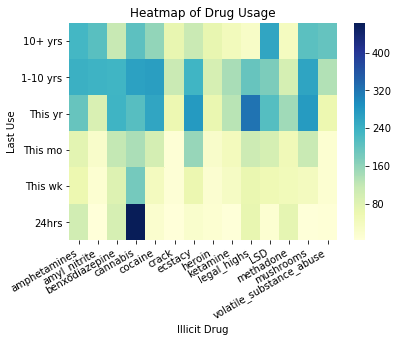

In [69]:
ax = sns.heatmap(use_pattern_df.drop('Never', axis=0),cmap="YlGnBu")
ax.set_xticklabels(use_pattern_df.columns, rotation=30, horizontalalignment='right')
ax.set_yticklabels(use_pattern_df.drop('Never', axis=0).index, rotation=0)
ax.set_title('Heatmap of Drug Usage')
ax.set_xlabel('Illicit Drug')
ax.set_ylabel('Last Use')
figure = ax.get_figure()    
figure.savefig('usage_heatmap.png', dpi=300, transparent=True, bbox_inches='tight');

## Defining Drug Users and Non-Users

**"User":**    
    Anyone who reports using an illegal drug within the past year
      
**"Non-User:**     
    Anyone who reports not having used any illegal drug within the past year  

In [70]:
# Defining users as 1 and non-users as 0
classes = {
    'CL0':0,
    'CL1':0,
    'CL2':0,
    'CL3':1,
    'CL4':1,
    'CL5':1,
    'CL6':1
}

In [71]:
# Replace class of user with 1 for user, 0 for non-user
df_buckets.replace(classes, inplace = True)

In [72]:
df_buckets.columns

Index(['age', 'gender', 'education_level', 'country', 'ethnicity',
       'neuroticism', 'extraversion', 'openness_to_experience',
       'agreeableness', 'conscientiousness', 'impulsivity',
       'sensation_seeking', 'amphetamines', 'amyl_nitrite', 'benxodiazepine',
       'cannabis', 'cocaine', 'crack', 'ecstacy', 'heroin', 'ketamine',
       'legal_highs', 'LSD', 'methadone', 'mushrooms', 'Semeron(placebo)',
       'volatile_substance_abuse', 'continent', 'divorce_rate', 'edu_exp_yr',
       'edu_mean_yr', 'gdp_pc', 'overall_life', 'female_life', 'male_life',
       '_25_64', '_25_34', '_35_44', '_45_54', '_55_64'],
      dtype='object')

In [73]:
# Create column called 'user', which will represent the sum of all positive drug use. 
df_buckets['user'] = (df_buckets.amphetamines + 
                     df_buckets.amyl_nitrite + 
                     df_buckets.benxodiazepine +
                     df_buckets.cocaine +
                     df_buckets.crack +
                     df_buckets.ecstacy +
                     df_buckets.heroin +
                     df_buckets.ketamine +
                     df_buckets.legal_highs +
                     df_buckets.LSD +
                     df_buckets.methadone +
                     df_buckets.mushrooms +
                     df_buckets.volatile_substance_abuse)

# Replace values > 0 with 'user' label, while giving others a 'non-user label'
df_buckets['user'] = df_buckets['user'].apply(lambda x: 1 if x > 0 else 0)

In [74]:
df_buckets.columns

Index(['age', 'gender', 'education_level', 'country', 'ethnicity',
       'neuroticism', 'extraversion', 'openness_to_experience',
       'agreeableness', 'conscientiousness', 'impulsivity',
       'sensation_seeking', 'amphetamines', 'amyl_nitrite', 'benxodiazepine',
       'cannabis', 'cocaine', 'crack', 'ecstacy', 'heroin', 'ketamine',
       'legal_highs', 'LSD', 'methadone', 'mushrooms', 'Semeron(placebo)',
       'volatile_substance_abuse', 'continent', 'divorce_rate', 'edu_exp_yr',
       'edu_mean_yr', 'gdp_pc', 'overall_life', 'female_life', 'male_life',
       '_25_64', '_25_34', '_35_44', '_45_54', '_55_64', 'user'],
      dtype='object')

## Create Dummy Variables

### Ethnicity

In [75]:
dummy_ethnic = pd.get_dummies(df_buckets['ethnicity'], drop_first = True).reset_index()

In [76]:
dummy_ethnic

,index,Black,Mixed-Black/Asian,Mixed-Black/White,Mixed-White/Asian,Other,White
0,0,0,0,0,1,0,0
1,1,0,0,0,0,0,1
2,2,0,0,0,0,0,1
3,3,0,0,0,0,0,1
4,4,0,0,0,0,0,1
...,...,...,...,...,...,...,...
1880,1880,0,0,0,0,0,1
1881,1881,0,0,0,0,0,1
1882,1882,0,0,0,0,0,1
1883,1883,0,0,0,0,0,1


In [77]:
df_buckets = pd.merge(df_buckets, dummy_ethnic, how = 'outer', left_index = True, right_index = True,  suffixes=(False, False))
df_buckets

,age,gender,education_level,country,ethnicity,neuroticism,extraversion,openness_to_experience,agreeableness,conscientiousness,...,_45_54,_55_64,user,index,Black,Mixed-Black/Asian,Mixed-Black/White,Mixed-White/Asian,Other,White
0,35.0,0.0,20.0,United Kingdom,Mixed-White/Asian,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,...,38.0,35.0,0,0,0,0,0,1,0,0
1,25.0,1.0,27.0,United Kingdom,White,-0.67825,1.93886,1.43533,0.76096,-0.14277,...,38.0,35.0,1,1,0,0,0,0,0,1
2,35.0,1.0,20.0,United Kingdom,White,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,...,38.0,35.0,0,2,0,0,0,0,0,1
3,18.0,0.0,23.0,United Kingdom,White,-0.14882,-0.80615,-0.01928,0.59042,0.58489,...,38.0,35.0,1,3,0,0,0,0,0,1
4,35.0,0.0,27.0,United Kingdom,White,0.73545,-1.63340,-0.45174,-0.30172,1.30612,...,38.0,35.0,0,4,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1880,18.0,0.0,19.0,United States,White,-1.19430,1.74091,1.88511,0.76096,-1.13788,...,43.0,41.0,1,1880,0,0,0,0,0,1
1881,18.0,1.0,19.0,United States,White,-0.24649,1.74091,0.58331,0.76096,-1.51840,...,43.0,41.0,1,1881,0,0,0,0,0,1
1882,25.0,0.0,21.0,United States,White,1.13281,-1.37639,-1.27553,-1.77200,-1.38502,...,43.0,41.0,1,1882,0,0,0,0,0,1
1883,18.0,0.0,19.0,United States,White,0.91093,-1.92173,0.29338,-1.62090,-2.57309,...,43.0,41.0,1,1883,0,0,0,0,0,1


In [78]:
df_buckets = df_buckets.drop(columns = 'index')
df_buckets

,age,gender,education_level,country,ethnicity,neuroticism,extraversion,openness_to_experience,agreeableness,conscientiousness,...,_35_44,_45_54,_55_64,user,Black,Mixed-Black/Asian,Mixed-Black/White,Mixed-White/Asian,Other,White
0,35.0,0.0,20.0,United Kingdom,Mixed-White/Asian,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,...,46.0,38.0,35.0,0,0,0,0,1,0,0
1,25.0,1.0,27.0,United Kingdom,White,-0.67825,1.93886,1.43533,0.76096,-0.14277,...,46.0,38.0,35.0,1,0,0,0,0,0,1
2,35.0,1.0,20.0,United Kingdom,White,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,...,46.0,38.0,35.0,0,0,0,0,0,0,1
3,18.0,0.0,23.0,United Kingdom,White,-0.14882,-0.80615,-0.01928,0.59042,0.58489,...,46.0,38.0,35.0,1,0,0,0,0,0,1
4,35.0,0.0,27.0,United Kingdom,White,0.73545,-1.63340,-0.45174,-0.30172,1.30612,...,46.0,38.0,35.0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1880,18.0,0.0,19.0,United States,White,-1.19430,1.74091,1.88511,0.76096,-1.13788,...,47.0,43.0,41.0,1,0,0,0,0,0,1
1881,18.0,1.0,19.0,United States,White,-0.24649,1.74091,0.58331,0.76096,-1.51840,...,47.0,43.0,41.0,1,0,0,0,0,0,1
1882,25.0,0.0,21.0,United States,White,1.13281,-1.37639,-1.27553,-1.77200,-1.38502,...,47.0,43.0,41.0,1,0,0,0,0,0,1
1883,18.0,0.0,19.0,United States,White,0.91093,-1.92173,0.29338,-1.62090,-2.57309,...,47.0,43.0,41.0,1,0,0,0,0,0,1


### Country

In [79]:
dummy_country = pd.get_dummies(df_buckets['country'], drop_first = True).reset_index()
dummy_country

,index,Canada,Ireland,New Zealand,Other,United Kingdom,United States
0,0,0,0,0,0,1,0
1,1,0,0,0,0,1,0
2,2,0,0,0,0,1,0
3,3,0,0,0,0,1,0
4,4,0,0,0,0,1,0
...,...,...,...,...,...,...,...
1880,1880,0,0,0,0,0,1
1881,1881,0,0,0,0,0,1
1882,1882,0,0,0,0,0,1
1883,1883,0,0,0,0,0,1


In [80]:
df_buckets = pd.merge(df_buckets, dummy_country, how = 'outer', left_index = True, right_index = True, suffixes=('_Ethnicity', '_Country'))
df_buckets

,age,gender,education_level,country,ethnicity,neuroticism,extraversion,openness_to_experience,agreeableness,conscientiousness,...,Mixed-White/Asian,Other_Ethnicity,White,index,Canada,Ireland,New Zealand,Other_Country,United Kingdom,United States
0,35.0,0.0,20.0,United Kingdom,Mixed-White/Asian,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,...,1,0,0,0,0,0,0,0,1,0
1,25.0,1.0,27.0,United Kingdom,White,-0.67825,1.93886,1.43533,0.76096,-0.14277,...,0,0,1,1,0,0,0,0,1,0
2,35.0,1.0,20.0,United Kingdom,White,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,...,0,0,1,2,0,0,0,0,1,0
3,18.0,0.0,23.0,United Kingdom,White,-0.14882,-0.80615,-0.01928,0.59042,0.58489,...,0,0,1,3,0,0,0,0,1,0
4,35.0,0.0,27.0,United Kingdom,White,0.73545,-1.63340,-0.45174,-0.30172,1.30612,...,0,0,1,4,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1880,18.0,0.0,19.0,United States,White,-1.19430,1.74091,1.88511,0.76096,-1.13788,...,0,0,1,1880,0,0,0,0,0,1
1881,18.0,1.0,19.0,United States,White,-0.24649,1.74091,0.58331,0.76096,-1.51840,...,0,0,1,1881,0,0,0,0,0,1
1882,25.0,0.0,21.0,United States,White,1.13281,-1.37639,-1.27553,-1.77200,-1.38502,...,0,0,1,1882,0,0,0,0,0,1
1883,18.0,0.0,19.0,United States,White,0.91093,-1.92173,0.29338,-1.62090,-2.57309,...,0,0,1,1883,0,0,0,0,0,1


In [81]:
df_buckets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1885 entries, 0 to 1884
Data columns (total 54 columns):
age                         1885 non-null float64
gender                      1885 non-null float64
education_level             1885 non-null float64
country                     1885 non-null object
ethnicity                   1885 non-null object
neuroticism                 1885 non-null float64
extraversion                1885 non-null float64
openness_to_experience      1885 non-null float64
agreeableness               1885 non-null float64
conscientiousness           1885 non-null float64
impulsivity                 1885 non-null float64
sensation_seeking           1885 non-null float64
amphetamines                1885 non-null int64
amyl_nitrite                1885 non-null int64
benxodiazepine              1885 non-null int64
cannabis                    1885 non-null int64
cocaine                     1885 non-null int64
crack                       1885 non-null int64
ecstacy

## Fill nulls

### Fill numerical nulls with mean

In [82]:
df_buckets = df_buckets.fillna(df_buckets.mean())
df_buckets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1885 entries, 0 to 1884
Data columns (total 54 columns):
age                         1885 non-null float64
gender                      1885 non-null float64
education_level             1885 non-null float64
country                     1885 non-null object
ethnicity                   1885 non-null object
neuroticism                 1885 non-null float64
extraversion                1885 non-null float64
openness_to_experience      1885 non-null float64
agreeableness               1885 non-null float64
conscientiousness           1885 non-null float64
impulsivity                 1885 non-null float64
sensation_seeking           1885 non-null float64
amphetamines                1885 non-null int64
amyl_nitrite                1885 non-null int64
benxodiazepine              1885 non-null int64
cannabis                    1885 non-null int64
cocaine                     1885 non-null int64
crack                       1885 non-null int64
ecstacy

### Fill continent null with 'unknown'

In [83]:
df_buckets = df_buckets.fillna('unknown')
df_buckets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1885 entries, 0 to 1884
Data columns (total 54 columns):
age                         1885 non-null float64
gender                      1885 non-null float64
education_level             1885 non-null float64
country                     1885 non-null object
ethnicity                   1885 non-null object
neuroticism                 1885 non-null float64
extraversion                1885 non-null float64
openness_to_experience      1885 non-null float64
agreeableness               1885 non-null float64
conscientiousness           1885 non-null float64
impulsivity                 1885 non-null float64
sensation_seeking           1885 non-null float64
amphetamines                1885 non-null int64
amyl_nitrite                1885 non-null int64
benxodiazepine              1885 non-null int64
cannabis                    1885 non-null int64
cocaine                     1885 non-null int64
crack                       1885 non-null int64
ecstacy

## Drop Bad Data

In [84]:
# There are 3 individuals who claimed they used the nonexistent control drug, Semeron.  
# They will be deleted from the data given they have over-reported their drug use. 

# id row location of liars
liars = df_buckets[(df_buckets['Semeron(placebo)'] == 1)].index

df_buckets = df_buckets.drop(liars, axis = 'index').reset_index(drop=True)
df_buckets

,age,gender,education_level,country,ethnicity,neuroticism,extraversion,openness_to_experience,agreeableness,conscientiousness,...,Mixed-White/Asian,Other_Ethnicity,White,index,Canada,Ireland,New Zealand,Other_Country,United Kingdom,United States
0,35.0,0.0,20.0,United Kingdom,Mixed-White/Asian,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,...,1,0,0,0,0,0,0,0,1,0
1,25.0,1.0,27.0,United Kingdom,White,-0.67825,1.93886,1.43533,0.76096,-0.14277,...,0,0,1,1,0,0,0,0,1,0
2,35.0,1.0,20.0,United Kingdom,White,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,...,0,0,1,2,0,0,0,0,1,0
3,18.0,0.0,23.0,United Kingdom,White,-0.14882,-0.80615,-0.01928,0.59042,0.58489,...,0,0,1,3,0,0,0,0,1,0
4,35.0,0.0,27.0,United Kingdom,White,0.73545,-1.63340,-0.45174,-0.30172,1.30612,...,0,0,1,4,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1877,18.0,0.0,19.0,United States,White,-1.19430,1.74091,1.88511,0.76096,-1.13788,...,0,0,1,1880,0,0,0,0,0,1
1878,18.0,1.0,19.0,United States,White,-0.24649,1.74091,0.58331,0.76096,-1.51840,...,0,0,1,1881,0,0,0,0,0,1
1879,25.0,0.0,21.0,United States,White,1.13281,-1.37639,-1.27553,-1.77200,-1.38502,...,0,0,1,1882,0,0,0,0,0,1
1880,18.0,0.0,19.0,United States,White,0.91093,-1.92173,0.29338,-1.62090,-2.57309,...,0,0,1,1883,0,0,0,0,0,1


## Full Data to CSV

In [85]:
df_buckets.to_csv('drugs_all_data_00.csv')

# EDA

## Class Balance

### User vs. Non-user

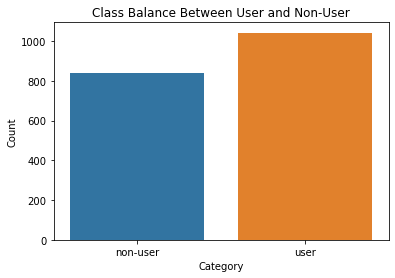

In [86]:
ax = sns.countplot(x = 'user', data = df_buckets)
ax.set(xticklabels = ['non-user', 'user'])
plt.ylabel('Count')
plt.xlabel('Category')
plt.title('Class Balance Between User and Non-User');
plt.savefig('class_balance.png')

### By Country

In [87]:
df_buckets.country.unique()

array(['United Kingdom', 'Canada', 'United States', 'Other', 'Australia',
       'Ireland', 'New Zealand'], dtype=object)

In [88]:
df_buckets[(df_buckets['United States']==1)&(df_buckets['user']==1)].count()

age                         506
gender                      506
education_level             506
country                     506
ethnicity                   506
neuroticism                 506
extraversion                506
openness_to_experience      506
agreeableness               506
conscientiousness           506
impulsivity                 506
sensation_seeking           506
amphetamines                506
amyl_nitrite                506
benxodiazepine              506
cannabis                    506
cocaine                     506
crack                       506
ecstacy                     506
heroin                      506
ketamine                    506
legal_highs                 506
LSD                         506
methadone                   506
mushrooms                   506
Semeron(placebo)            506
volatile_substance_abuse    506
continent                   506
divorce_rate                506
edu_exp_yr                  506
edu_mean_yr                 506
gdp_pc  

In [89]:
df_buckets.groupby(['user'])['United Kingdom', 'Canada', 'United States', 'Other_Country',
       'Ireland', 'New Zealand'].sum()

,United Kingdom,Canada,United States,Other_Country,Ireland,New Zealand
user,,,,,,
0,716.0,32.0,49.0,28.0,6.0,1.0
1,328.0,55.0,506.0,90.0,14.0,4.0


The United States and United Kingdom make up a majority of the respondents and almost 1/2 of the users.  

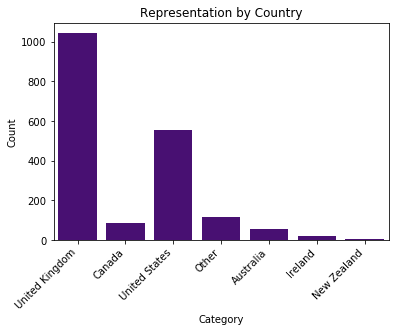

In [90]:
ax = sns.countplot(x = 'country', color = 'indigo', data = df_buckets)
ax.set(xticklabels = ['United Kingdom', 'Canada', 'United States', 'Other', 'Australia',
       'Ireland', 'New Zealand'])
plt.xticks(rotation=45, ha='right')
plt.ylabel('Count')
plt.xlabel('Category')
plt.title('Representation by Country');
plt.savefig('country_balance.png')

## Pair Plot

In [91]:
# ax1 = sns.pairplot(df_buckets, hue = 'user', diag_kind='kde')
# ax1.savefig('pairplot.png');

# Split Data

In [92]:
# drop drug columns
X = df_buckets.drop(columns = ['user', 'ethnicity','country', 'index','amphetamines', 'amyl_nitrite', 'benxodiazepine',
                               'cannabis', 'cocaine', 'crack', 'ecstacy', 'heroin', 'ketamine', 'legal_highs', 
                               'LSD', 'methadone', 'mushrooms', 'Semeron(placebo)','volatile_substance_abuse','continent'] 
                                , axis = 1)
y = df_buckets.user

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 9)

In [93]:
X

,age,gender,education_level,neuroticism,extraversion,openness_to_experience,agreeableness,conscientiousness,impulsivity,sensation_seeking,...,Mixed-Black/White,Mixed-White/Asian,Other_Ethnicity,White,Canada,Ireland,New Zealand,Other_Country,United Kingdom,United States
0,35.0,0.0,20.0,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,-0.21712,-1.18084,...,0,1,0,0,0,0,0,0,1,0
1,25.0,1.0,27.0,-0.67825,1.93886,1.43533,0.76096,-0.14277,-0.71126,-0.21575,...,0,0,0,1,0,0,0,0,1,0
2,35.0,1.0,20.0,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,-1.37983,0.40148,...,0,0,0,1,0,0,0,0,1,0
3,18.0,0.0,23.0,-0.14882,-0.80615,-0.01928,0.59042,0.58489,-1.37983,-1.18084,...,0,0,0,1,0,0,0,0,1,0
4,35.0,0.0,27.0,0.73545,-1.63340,-0.45174,-0.30172,1.30612,-0.21712,-0.21575,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1877,18.0,0.0,19.0,-1.19430,1.74091,1.88511,0.76096,-1.13788,0.88113,1.92173,...,0,0,0,1,0,0,0,0,0,1
1878,18.0,1.0,19.0,-0.24649,1.74091,0.58331,0.76096,-1.51840,0.88113,0.76540,...,0,0,0,1,0,0,0,0,0,1
1879,25.0,0.0,21.0,1.13281,-1.37639,-1.27553,-1.77200,-1.38502,0.52975,-0.52593,...,0,0,0,1,0,0,0,0,0,1
1880,18.0,0.0,19.0,0.91093,-1.92173,0.29338,-1.62090,-2.57309,1.29221,1.22470,...,0,0,0,1,0,0,0,0,0,1


# Dummy Model

In [94]:
y_pred_user = drugslib.dummy_pred(X_test, 1)

## Dummy Accuracy Score

In [95]:
print(f'Accuracy score for dummy model: {100*accuracy_score(y_test, y_pred_user):1.3f}%')

Accuracy score for dummy model: 55.929%


In [96]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1882 entries, 0 to 1881
Data columns (total 34 columns):
age                       1882 non-null float64
gender                    1882 non-null float64
education_level           1882 non-null float64
neuroticism               1882 non-null float64
extraversion              1882 non-null float64
openness_to_experience    1882 non-null float64
agreeableness             1882 non-null float64
conscientiousness         1882 non-null float64
impulsivity               1882 non-null float64
sensation_seeking         1882 non-null float64
divorce_rate              1882 non-null float64
edu_exp_yr                1882 non-null float64
edu_mean_yr               1882 non-null float64
gdp_pc                    1882 non-null float64
overall_life              1882 non-null float64
female_life               1882 non-null float64
male_life                 1882 non-null float64
_25_64                    1882 non-null float64
_25_34                    188

# Iteration 00

## Train/Test (no CV) - All Models

### ROC Curve - All Models

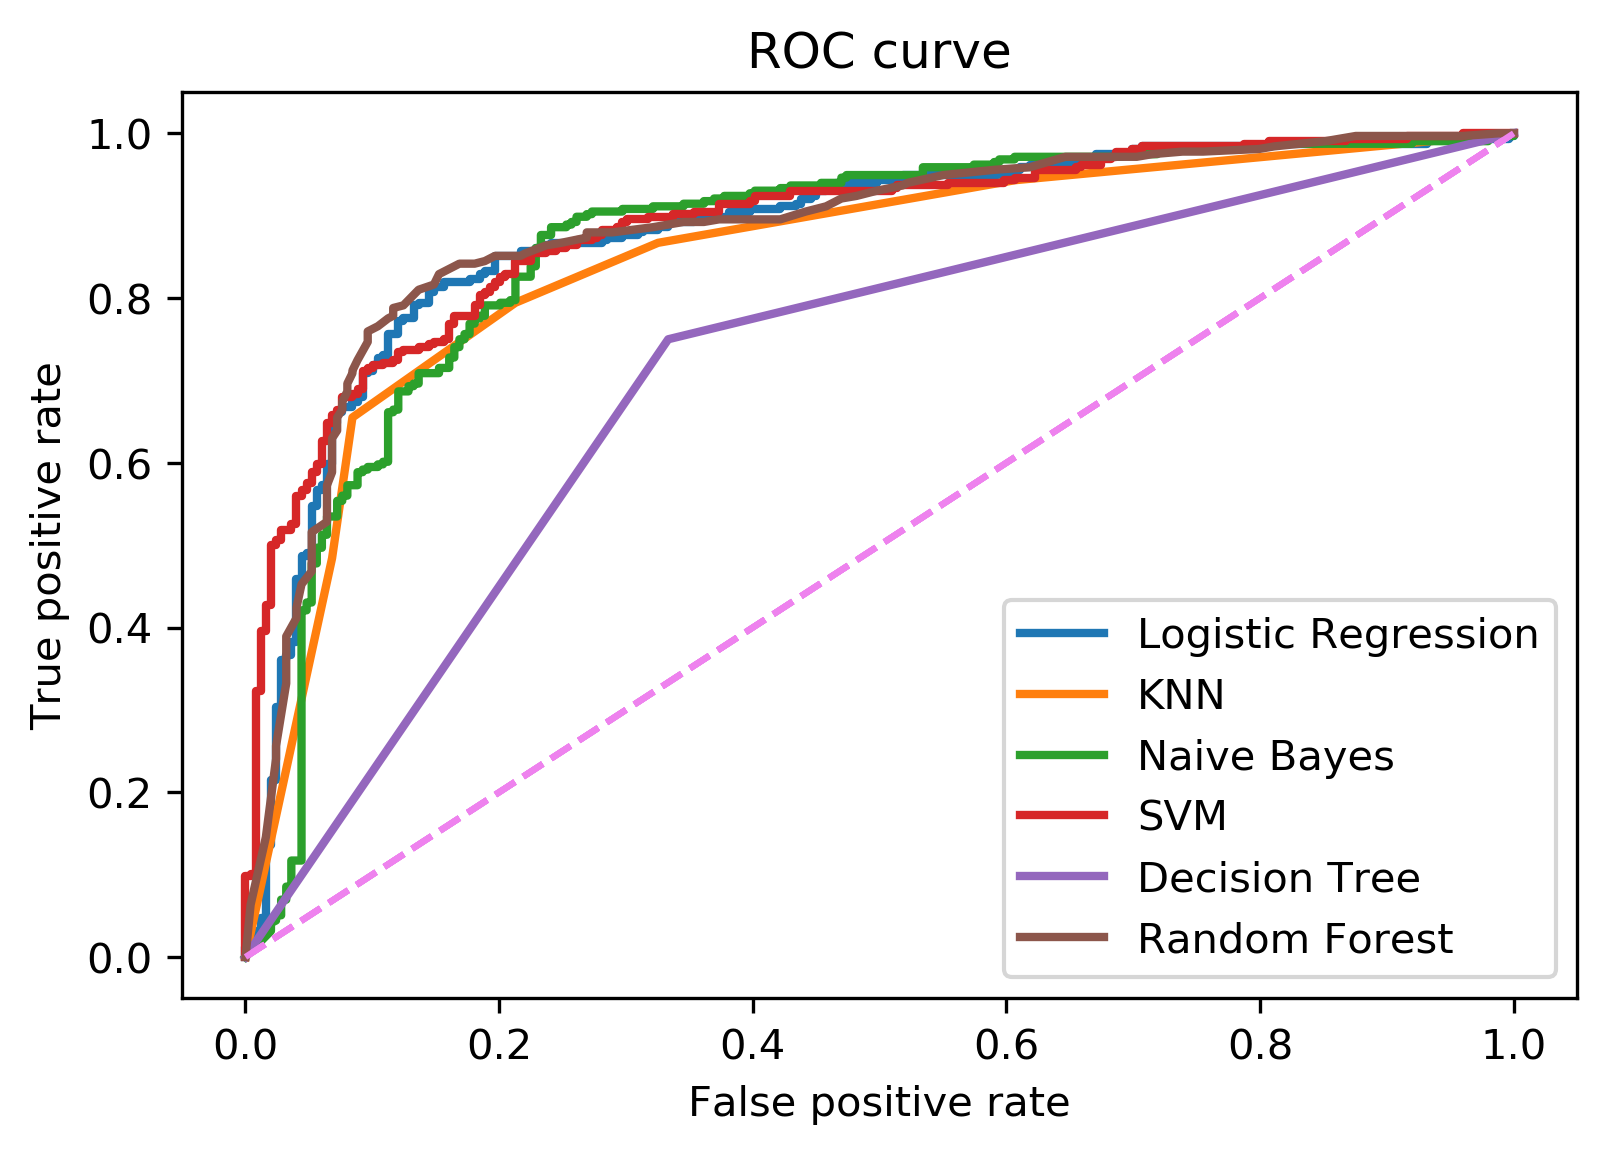

In [97]:
# ROC curve for all models 
scores = drugslib.run_models(X, y)

### Metrics Comparison - All Models

In [98]:
(scores.style.set_properties(**{'text-align': 'center'})
            .set_table_styles([ dict(selector='th', props=[('text-align', 'center'),('max-width', '80px')] ) ]))

,Logistic Regression,KNN,Naive Bayes,SVM,Decision Tree,Random Forest
Accuracy,0.8248,0.7912,0.7628,0.7982,0.7133,0.8372
Precision,0.8807,0.8257,0.876,0.8483,0.7406,0.8733
Recall,0.7943,0.7943,0.6709,0.7785,0.75,0.8291
F1,0.8353,0.8097,0.7599,0.8119,0.7453,0.8506


## CV - All Models

,Logistic Regression,KNN,Naive Bayes,SVM,Decision Tree,Random Forest
Accuracy (train),0.7842,0.8265,0.7591,0.8352,1.0000,1.0000
Accuracy (test),0.7820,0.7661,0.7600,0.7798,0.7221,0.7987
Precision,0.8364,0.8545,0.8715,0.8773,1.0000,1.0000
Recall,0.7586,0.8261,0.6605,0.8154,1.0000,1.0000
F1,0.7949,0.8400,0.7514,0.8451,1.0000,1.0000
AUC,0.8593,0.9199,0.8718,0.9260,1.0000,1.0000


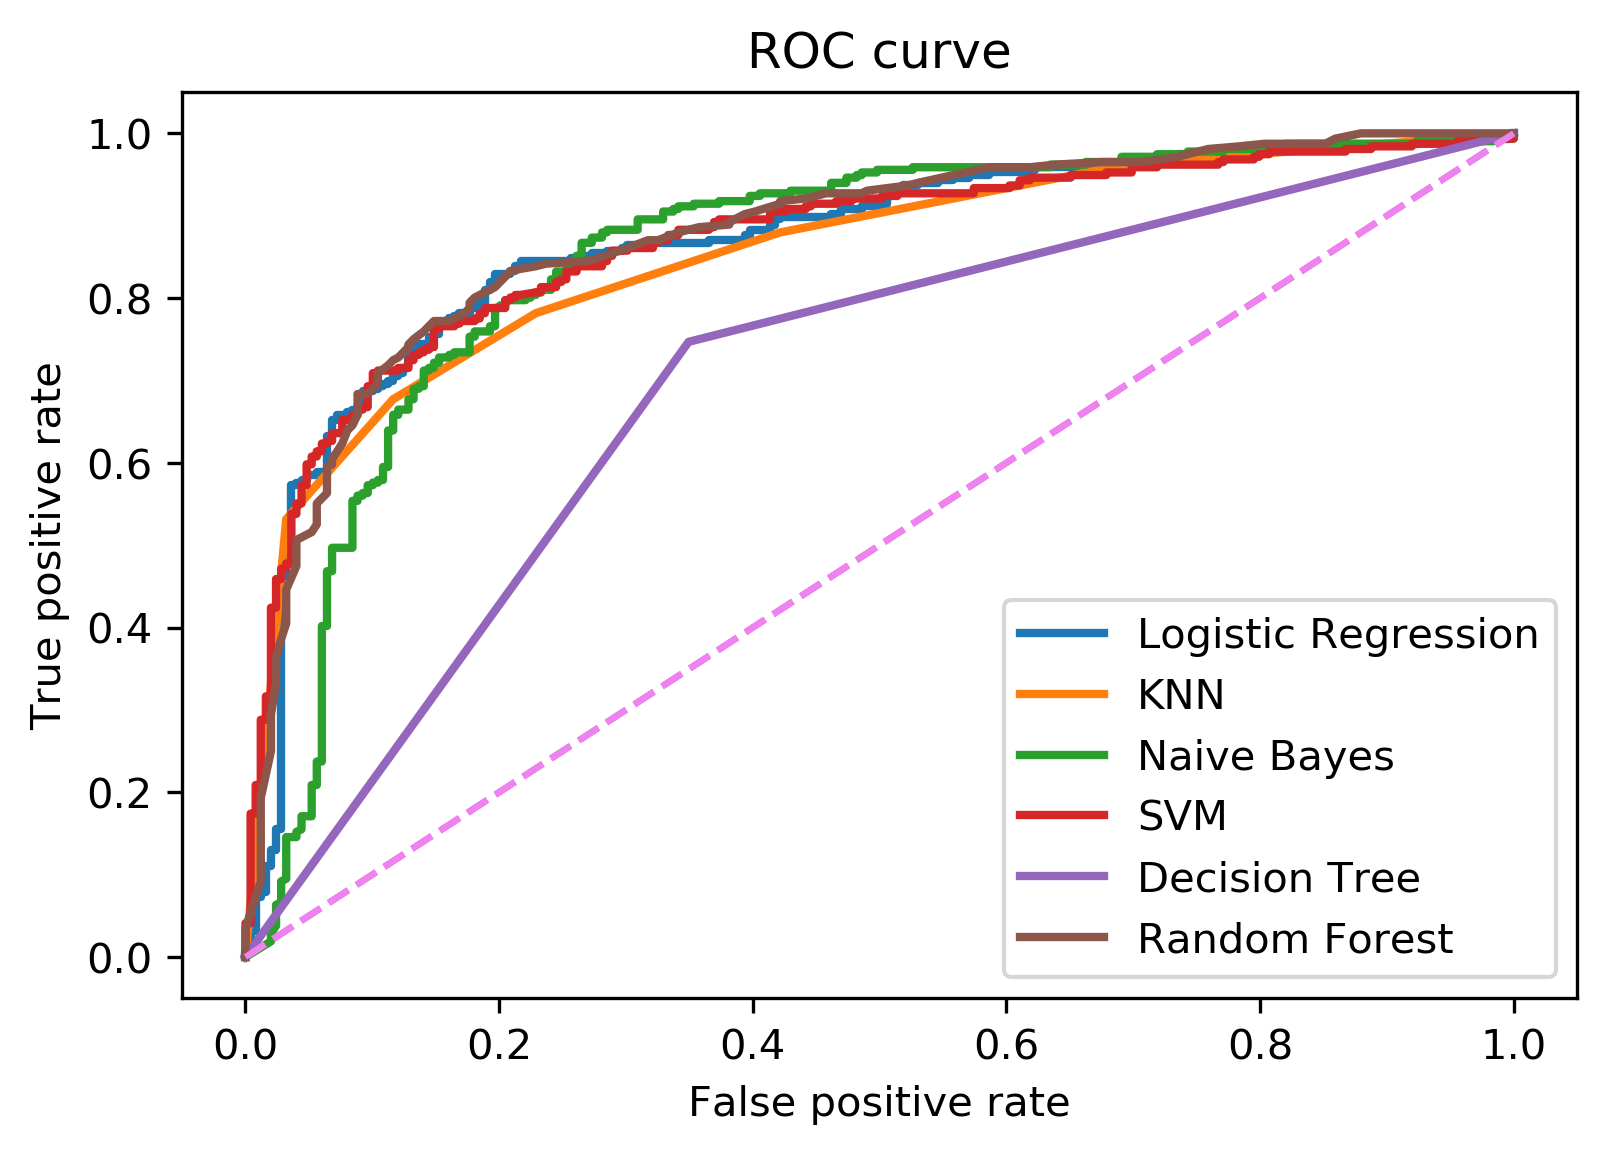

In [99]:
# ROC and Metrics
drugslib.run_CVmodels(X, y)

## Logistic Regresion CV Solo

In [100]:
drugslib??

,Logistic_RegressionCV
Accuracy(train),0.7820
Precision,0.8346
Recall,0.7548
F1,0.7910
AUC,0.8682


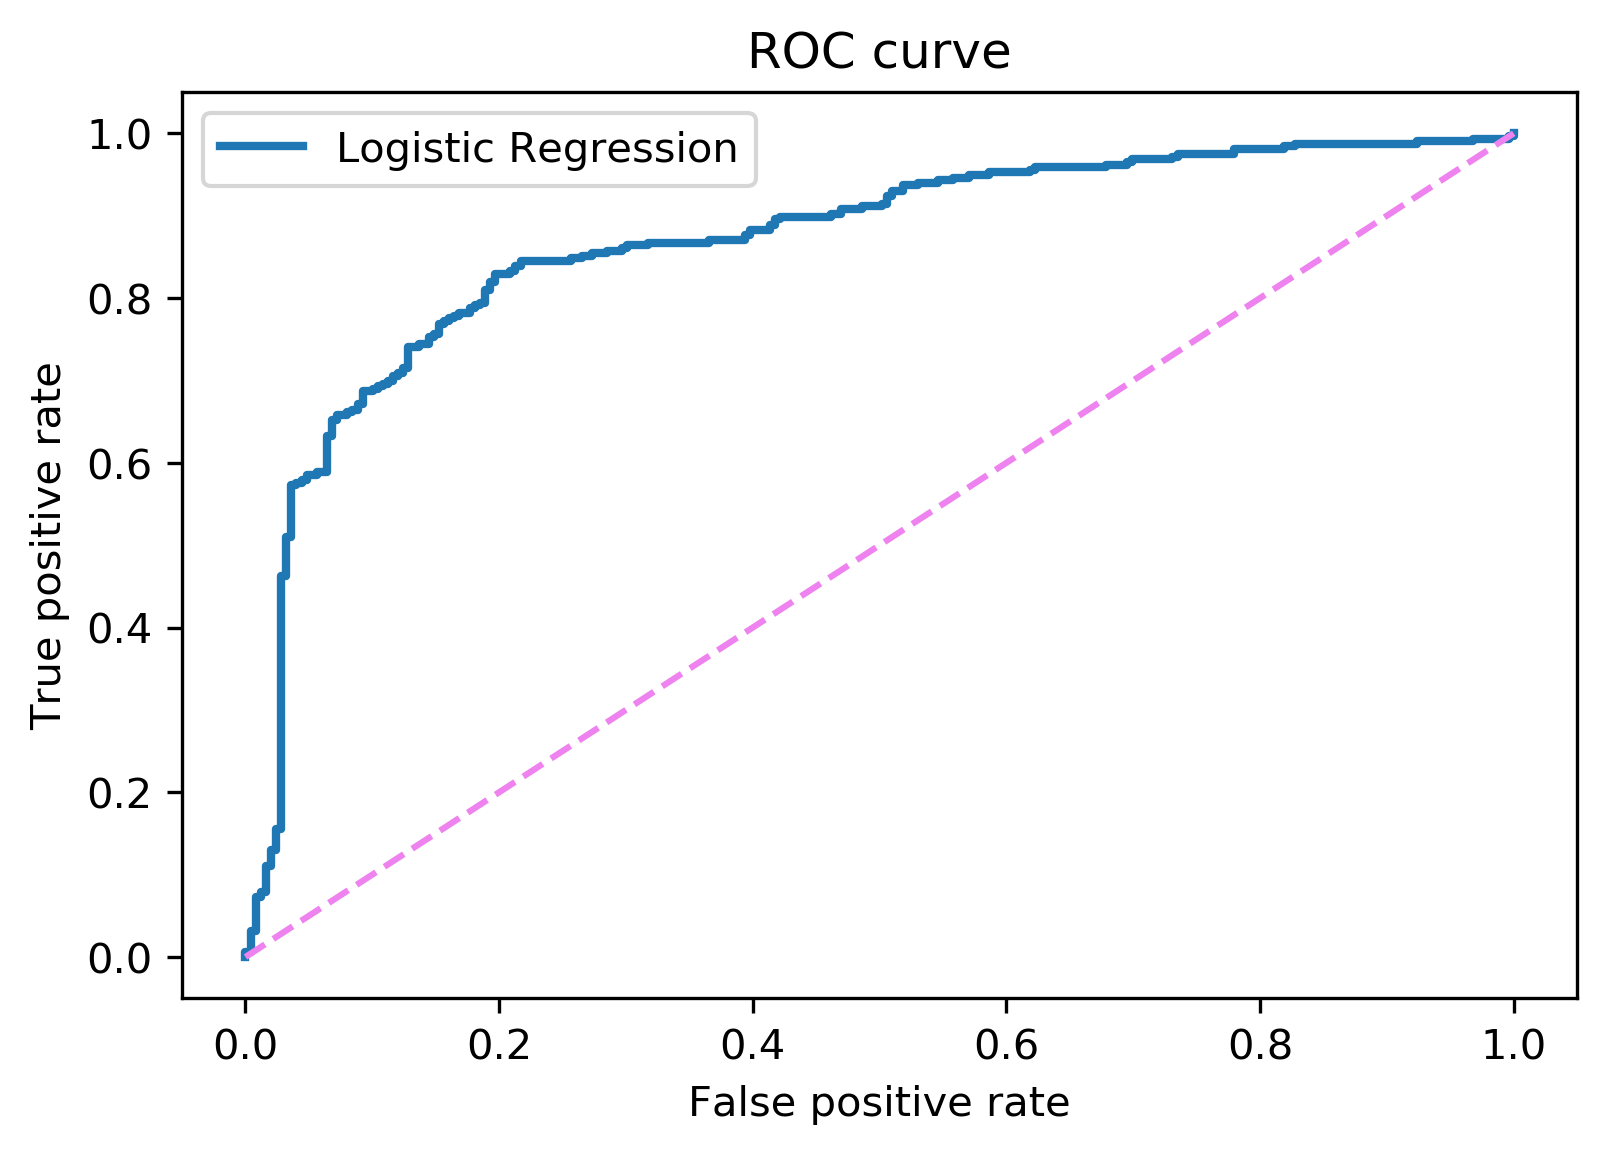

In [101]:
drugslib.logis_regrCV(X, y)

## Random Forest CV Solo


Features sorted by their score for estimator 0:

                        importance
edu_mean_yr                 0.1017
United Kingdom              0.0767
sensation_seeking           0.0722
edu_exp_yr                  0.0716
gdp_pc                      0.0572
conscientiousness           0.0532
age                         0.0519
_25_34                      0.0486
_35_44                      0.0484
divorce_rate                0.0456
openness_to_experience      0.0436
impulsivity                 0.0403
male_life                   0.0378
female_life                 0.0363
_55_64                      0.0327
neuroticism                 0.0323
overall_life                0.0318
extraversion                0.0221
education_level             0.0217
_25_64                      0.0206
agreeableness               0.0184
gender                      0.0152
United States               0.0121
_45_54                      0.0034
Canada                      0.0019
Other_Ethnicity             0.0010
White

,Random_ForestCV
Accuracy (train),0.8240
Accuracy (test),0.7896
Accuracy (diff),0.0344
Precision,0.8836
Recall,0.7841
F1,0.8308
AUC,0.9147


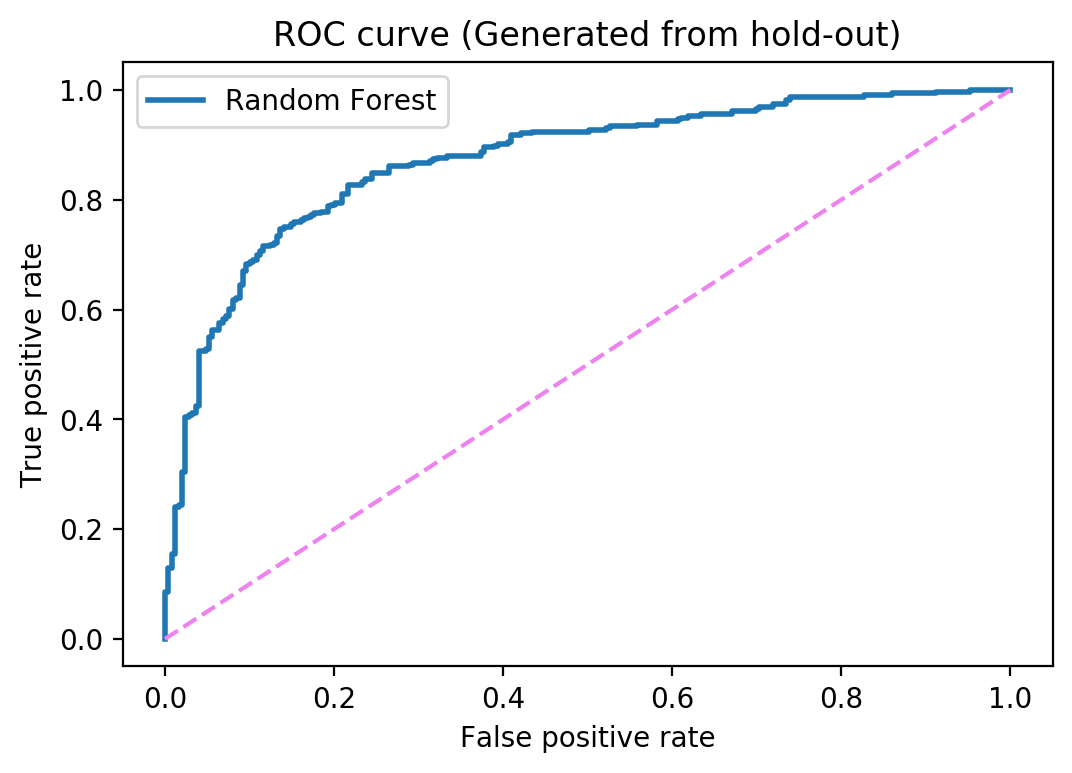

In [102]:
drugslib.rand_forestCV(X,y)

In [103]:
train_sizes, train_err, ts_err = learning_curve(RandomForestClassifier(n_estimators = 100), X_train, y_train, random_state=9)
print(f'learning curve ({train_err})\n {ts_err}')

/Users/AKE/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


learning curve ([[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]])
 [[0.76082005 0.79954442 0.79498861]
 [0.79271071 0.82232346 0.79271071]
 [0.78359909 0.82232346 0.79954442]
 [0.77448747 0.82915718 0.80182232]
 [0.77220957 0.82915718 0.79726651]]


In [104]:
train_cv_err = np.mean(train_err, axis=1)
train_cv_std = np.std(train_err, axis=1)
test_cv_err = np.mean(ts_err, axis=1)
test_cv_std = np.std(ts_err, axis=1)

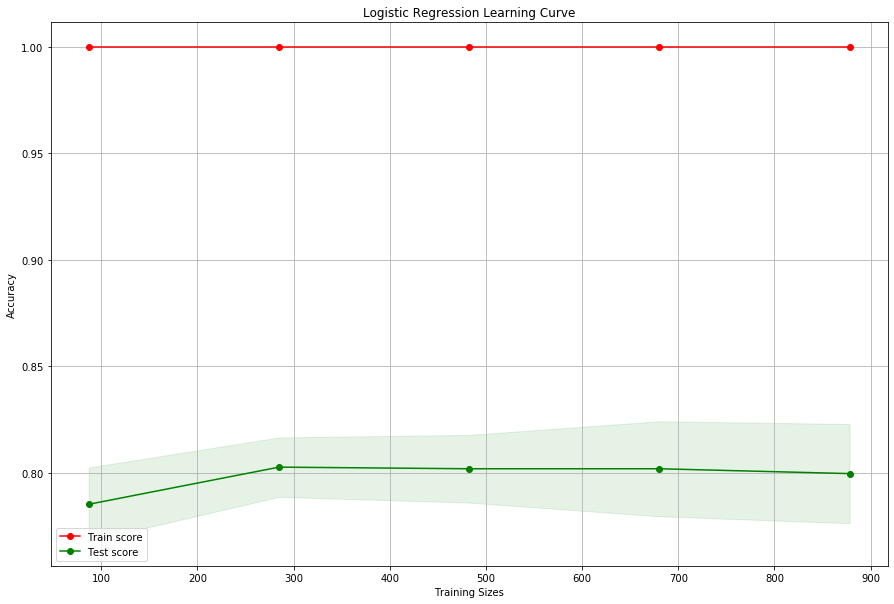

In [105]:
# Plot learning curve
fig, axes = plt.subplots(1, 1, figsize=(15, 10))
axes.grid()
axes.fill_between(train_sizes, train_cv_err - train_cv_std,
                     train_cv_err + train_cv_std, alpha=0.1,
                     color="r")
axes.fill_between(train_sizes, test_cv_err - test_cv_std,
                     test_cv_err + test_cv_std, alpha=0.1,
                     color="g")
axes.plot(train_sizes, train_cv_err, 'o-', color="r",
             label="Train score")
axes.plot(train_sizes, test_cv_err, 'o-', color="g",
             label="Test score")
axes.legend(loc="best")
plt.ylabel('Accuracy')
plt.xlabel('Training Sizes')
plt.title('Logistic Regression Learning Curve')
plt.show()

## Confusion Matrix

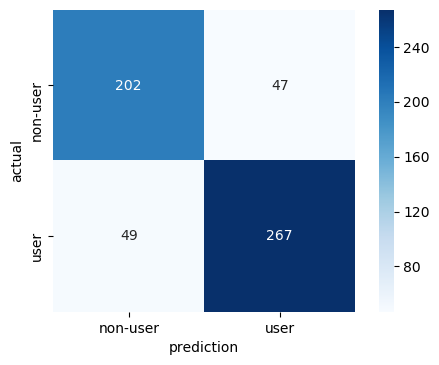

<Figure size 720x720 with 0 Axes>

In [107]:
rf = RandomForestClassifier(n_estimators = 100)
rf.fit(X_train, y_train)
drugslib.make_confusion_matrix(rf, X_test, y_test, threshold=0.450);
plt.savefig('Confusion_CV.png');

## Precision-Recall vs. Threshold

(0, 1)

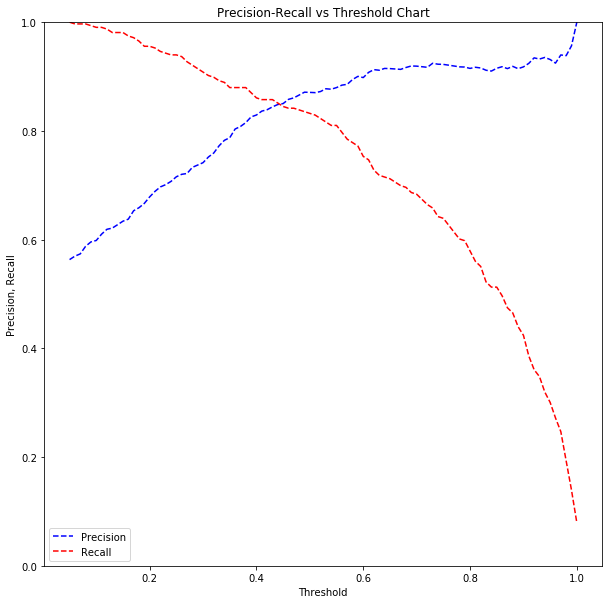

In [108]:
pred_y = rf.predict(X_test) 
probs_y = rf.predict_proba(X_test) 
from sklearn.metrics import precision_recall_curve, auc
precision, recall, thresholds = precision_recall_curve(y_test, probs_y[:, 1]) 
pr_auc = auc(recall, precision)
plt.figure(figsize = (10, 10))
plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])

# Iteration 01

## Load Data

In [109]:
data01 = pd.read_csv('drugs_all_data_00.csv')

In [110]:
data01.columns

Index(['Unnamed: 0', 'age', 'gender', 'education_level', 'country',
       'ethnicity', 'neuroticism', 'extraversion', 'openness_to_experience',
       'agreeableness', 'conscientiousness', 'impulsivity',
       'sensation_seeking', 'amphetamines', 'amyl_nitrite', 'benxodiazepine',
       'cannabis', 'cocaine', 'crack', 'ecstacy', 'heroin', 'ketamine',
       'legal_highs', 'LSD', 'methadone', 'mushrooms', 'Semeron(placebo)',
       'volatile_substance_abuse', 'continent', 'divorce_rate', 'edu_exp_yr',
       'edu_mean_yr', 'gdp_pc', 'overall_life', 'female_life', 'male_life',
       '_25_64', '_25_34', '_35_44', '_45_54', '_55_64', 'user', 'Black',
       'Mixed-Black/Asian', 'Mixed-Black/White', 'Mixed-White/Asian',
       'Other_Ethnicity', 'White', 'index', 'Canada', 'Ireland', 'New Zealand',
       'Other_Country', 'United Kingdom', 'United States'],
      dtype='object')

## Feature Engineering

**Columns that will be added this iteration**  
edu_vs_exp = subject's education level divided by the expected level for their country of residence
edu_vs_mean = subject's education level divided by the mean level for their country of residence
age_vs_exp = subject's age compared to their life expectancy by country and sex

In [111]:
# create education columns
data01['edu_vs_exp'] = data01['education_level']/data01['edu_exp_yr']
data01['edu_vs_mean'] = data01['education_level']/data01['edu_mean_yr']

In [112]:
# create column to represent % of expected life lived
data01['age_vs_exp'] = data01['age']/(np.where(data01['gender']==0, data01['female_life'], 
                                                                    data01['male_life']))
data01.head()

,Unnamed: 0,age,gender,education_level,country,ethnicity,neuroticism,extraversion,openness_to_experience,agreeableness,...,index,Canada,Ireland,New Zealand,Other_Country,United Kingdom,United States,edu_vs_exp,edu_vs_mean,age_vs_exp
0,0,35.0,0.0,20.0,United Kingdom,Mixed-White/Asian,0.3129,-0.5755,-0.5833,-0.9170,...,0,0,0,0,0,1,0,1.2270,1.5038,0.4217
1,1,25.0,1.0,27.0,United Kingdom,White,-0.6783,1.9389,1.4353,0.7610,...,1,0,0,0,0,1,0,1.6564,2.0301,0.3145
2,2,35.0,1.0,20.0,United Kingdom,White,-0.4672,0.8052,-0.8473,-1.6209,...,2,0,0,0,0,1,0,1.2270,1.5038,0.4403
3,3,18.0,0.0,23.0,United Kingdom,White,-0.1488,-0.8062,-0.0193,0.5904,...,3,0,0,0,0,1,0,1.4110,1.7293,0.2169
4,4,35.0,0.0,27.0,United Kingdom,White,0.7355,-1.6334,-0.4517,-0.3017,...,4,0,0,0,0,1,0,1.6564,2.0301,0.4217


## Defining Iteration 01 Data

**Columns that will be dropped this iteration:**  
'amphetamines',   
'amyl_nitrite',   
'benxodiazepine',  
'cannabis',   
'cocaine',   
'crack',    
'ecstacy',   
'heroin',   
'ketamine',  
'legal_highs',   
'LSD',   
'methadone',   
'mushrooms',   
'Semeron(placebo)',  
'volatile_substance_abuse',   
'continent',   
'divorce_rate',   
'Unnamed: 0',    
'ethnicity',   
'country',  
'_25_64',  
'_25_34',  
'_35_44',  
'_45_54',  
'_55_64',
'education_level',
'edu_exp_yr',  
'edu_mean_yr',  
'overall_life',   
'female_life',   
'male_life',  
'user'  
       

In [113]:
X1 = data01.drop(['amphetamines',   
'amyl_nitrite',   
'benxodiazepine',  
'cannabis',   
'cocaine',   
'crack',    
'ecstacy',   
'heroin',   
'ketamine',  
'legal_highs',   
'LSD',   
'methadone',   
'mushrooms',   
'Semeron(placebo)',  
'volatile_substance_abuse',   
'continent',   
'divorce_rate',   
'Unnamed: 0',    
'ethnicity',   
'country',  
'_25_64',  
'_25_34',  
'_35_44',  
'_45_54',  
'_55_64',
'education_level',
'edu_exp_yr',  
'edu_mean_yr',  
'overall_life',   
'female_life',   
'male_life',
'index',
# 'age',
'Canada',  
'Ireland',  
'New Zealand',  
'Other_Country',  
'United Kingdom',  
'United States',
# 'gdp_pc', 
# 'Black',  
# 'Mixed-Black/Asian',  
# 'Mixed-Black/White',  
# 'Mixed-White/Asian',  
# 'Other_Ethnicity',   
# 'White',
'user'], axis = 1)

y1 = data01.user

In [114]:
X1.head()

,age,gender,neuroticism,extraversion,openness_to_experience,agreeableness,conscientiousness,impulsivity,sensation_seeking,gdp_pc,Black,Mixed-Black/Asian,Mixed-Black/White,Mixed-White/Asian,Other_Ethnicity,White,edu_vs_exp,edu_vs_mean,age_vs_exp
0,35.0,0.0,0.3129,-0.5755,-0.5833,-0.9170,-0.0066,-0.2171,-1.1808,39532.0,0,0,0,1,0,0,1.2270,1.5038,0.4217
1,25.0,1.0,-0.6783,1.9389,1.4353,0.7610,-0.1428,-0.7113,-0.2157,39532.0,0,0,0,0,0,1,1.6564,2.0301,0.3145
2,35.0,1.0,-0.4672,0.8052,-0.8473,-1.6209,-1.0145,-1.3798,0.4015,39532.0,0,0,0,0,0,1,1.2270,1.5038,0.4403
3,18.0,0.0,-0.1488,-0.8062,-0.0193,0.5904,0.5849,-1.3798,-1.1808,39532.0,0,0,0,0,0,1,1.4110,1.7293,0.2169
4,35.0,0.0,0.7355,-1.6334,-0.4517,-0.3017,1.3061,-0.2171,-0.2157,39532.0,0,0,0,0,0,1,1.6564,2.0301,0.4217


In [115]:
X1.columns

Index(['age', 'gender', 'neuroticism', 'extraversion',
       'openness_to_experience', 'agreeableness', 'conscientiousness',
       'impulsivity', 'sensation_seeking', 'gdp_pc', 'Black',
       'Mixed-Black/Asian', 'Mixed-Black/White', 'Mixed-White/Asian',
       'Other_Ethnicity', 'White', 'edu_vs_exp', 'edu_vs_mean', 'age_vs_exp'],
      dtype='object')

## Random Forest CV 01


Features sorted by their score for estimator 0:

                        importance
gdp_pc                      0.2469
sensation_seeking           0.1562
age_vs_exp                  0.1201
openness_to_experience      0.0816
age                         0.0792
conscientiousness           0.0572
edu_vs_exp                  0.0555
impulsivity                 0.0503
edu_vs_mean                 0.0492
neuroticism                 0.0465
extraversion                0.0211
agreeableness               0.0189
gender                      0.0153
White                       0.0011
Other_Ethnicity             0.0007
Black                       0.0002
Mixed-Black/Asian           0.0000
Mixed-Black/White           0.0000
Mixed-White/Asian           0.0000



Features sorted by their score for estimator 1:

                        importance
gdp_pc                      0.2261
age_vs_exp                  0.1404
age                         0.1154
sensation_seeking           0.1108
edu_vs_exp             

,Random_ForestCV
Accuracy (train),0.8472
Accuracy (test),0.8033
Accuracy (diff),0.0439
Precision,0.8739
Recall,0.8447
F1,0.8590
AUC,0.9303


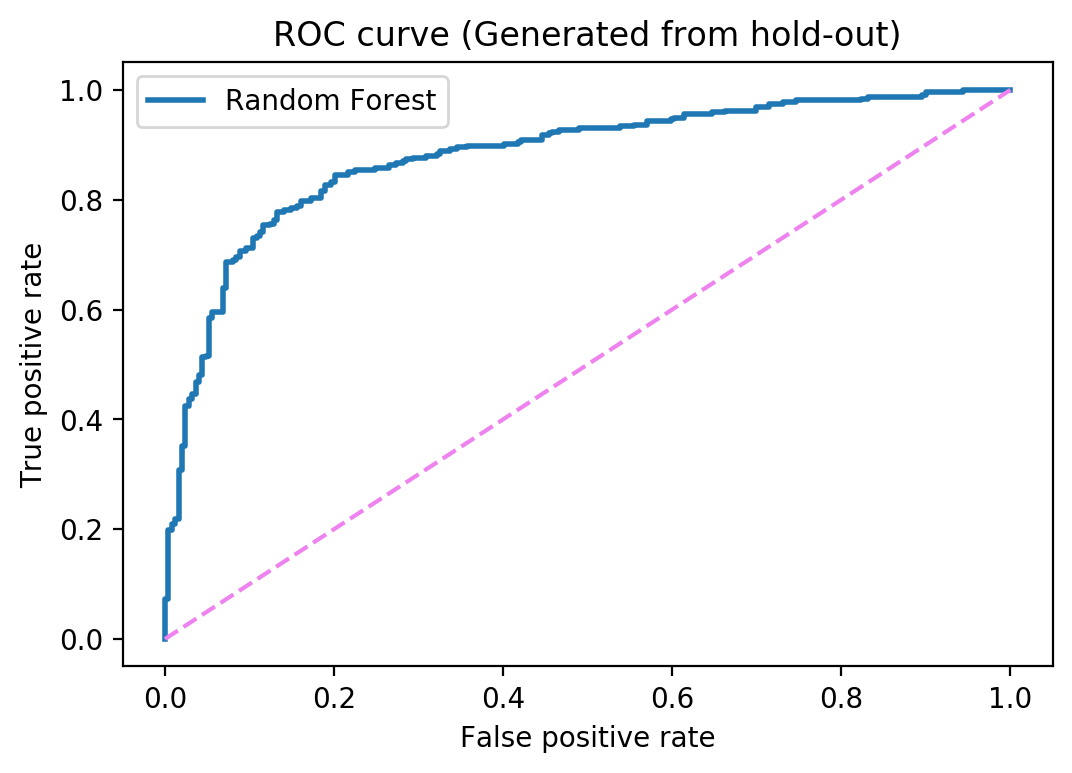

In [116]:
drugslib.rand_forestCV(X1,y1)

## Save Itr 01 Dataset to CSV

In [117]:
# Merging X1 with y1 and saving to new CSV
data01_used = pd.merge(X1, y1, left_index = True, right_index = True)

# Save out new CSV for reference.
data01_used.to_csv('drugs_all_data_01.csv')

# Iteration 02

## Load Data

In [118]:
data02 = pd.read_csv('drugs_all_data_01.csv', index_col=0) # index_col=0 prevents the unnamed: 0 col from being added

In [119]:
data02.columns

Index(['age', 'gender', 'neuroticism', 'extraversion',
       'openness_to_experience', 'agreeableness', 'conscientiousness',
       'impulsivity', 'sensation_seeking', 'gdp_pc', 'Black',
       'Mixed-Black/Asian', 'Mixed-Black/White', 'Mixed-White/Asian',
       'Other_Ethnicity', 'White', 'edu_vs_exp', 'edu_vs_mean', 'age_vs_exp',
       'user'],
      dtype='object')

## Feature Engineering - Big5

**Columns that will be added this iteration**  
big5 = (sensation_seeking + openness + neuroticism + impulsivity)/(conscientiousness + edu + age)

In [120]:
data02['big5'] = ( ((data02['gender']+1)**2) * (
    ( data02['sensation_seeking'] + data02['openness_to_experience'] + 
         data02['neuroticism'] + data02['impulsivity'] ) / 
    (data02['conscientiousness'] + data02['age'])
                ))


data02.head()


,age,gender,neuroticism,extraversion,openness_to_experience,agreeableness,conscientiousness,impulsivity,sensation_seeking,gdp_pc,...,Mixed-Black/Asian,Mixed-Black/White,Mixed-White/Asian,Other_Ethnicity,White,edu_vs_exp,edu_vs_mean,age_vs_exp,user,big5
0,35.0,0.0,0.3129,-0.5755,-0.5833,-0.9170,-0.0066,-0.2171,-1.1808,39532.0,...,0,0,1,0,0,1.2270,1.5038,0.4217,0,-0.0477
1,25.0,1.0,-0.6783,1.9389,1.4353,0.7610,-0.1428,-0.7113,-0.2157,39532.0,...,0,0,0,0,1,1.6564,2.0301,0.3145,1,-0.0273
2,35.0,1.0,-0.4672,0.8052,-0.8473,-1.6209,-1.0145,-1.3798,0.4015,39532.0,...,0,0,0,0,1,1.2270,1.5038,0.4403,0,-0.2699
3,18.0,0.0,-0.1488,-0.8062,-0.0193,0.5904,0.5849,-1.3798,-1.1808,39532.0,...,0,0,0,0,1,1.4110,1.7293,0.2169,1,-0.1468
4,35.0,0.0,0.7355,-1.6334,-0.4517,-0.3017,1.3061,-0.2171,-0.2157,39532.0,...,0,0,0,0,1,1.6564,2.0301,0.4217,0,-0.0041


In [121]:
data02.big5[data02['user']==1].describe()

count    1042.0000
mean        0.1682
std         0.3559
min        -1.0206
25%        -0.0240
50%         0.0938
75%         0.3102
max         1.6475
Name: big5, dtype: float64

In [122]:
data02.big5[data02['user']==0].describe()

count    840.0000
mean      -0.0657
std        0.1888
min       -0.8467
25%       -0.1231
50%       -0.0606
75%        0.0045
max        1.2272
Name: big5, dtype: float64

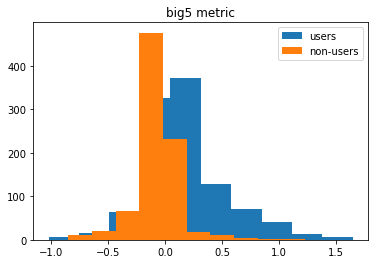

In [123]:
# histogram of big5 metric distribution between users and non-users
plt.hist(data02.big5[data02['user']==1], label = 'users')
plt.hist(data02.big5[data02['user']==0], label = 'non-users')
plt.title('big5 metric')
plt.legend();

## Defining Iteration 02 Data

In [124]:
data02.columns

Index(['age', 'gender', 'neuroticism', 'extraversion',
       'openness_to_experience', 'agreeableness', 'conscientiousness',
       'impulsivity', 'sensation_seeking', 'gdp_pc', 'Black',
       'Mixed-Black/Asian', 'Mixed-Black/White', 'Mixed-White/Asian',
       'Other_Ethnicity', 'White', 'edu_vs_exp', 'edu_vs_mean', 'age_vs_exp',
       'user', 'big5'],
      dtype='object')

In [125]:
# Columns that are commented out are kept in the model

X2 = data02.drop(['user',
#                   'age', 
#                   'gender', 
#                   'neuroticism', 
#                   'extraversion',
#                   'openness_to_experience', 
#                   'agreeableness', 
#                   'conscientiousness',
#                   'impulsivity', 
#                   'sensation_seeking', 
#                   'gdp_pc', 
#                   'Black',
                  'Mixed-Black/Asian', 
#                   'Mixed-Black/White', 
                  'Mixed-White/Asian',
#                   'Other_Ethnicity', 
#                   'White', 
#                   'edu_vs_exp', 
#                   'edu_vs_mean', 
#                   'age_vs_exp',
#                   'big5'
                 ], axis = 1)

y2 = data02.user

## Random Forest CV 02


Features sorted by their score for estimator 0:

                        importance
gdp_pc                      0.2834
big5                        0.1735
sensation_seeking           0.1144
age_vs_exp                  0.0734
age                         0.0621
edu_vs_exp                  0.0608
openness_to_experience      0.0570
conscientiousness           0.0476
edu_vs_mean                 0.0330
impulsivity                 0.0237
neuroticism                 0.0228
extraversion                0.0182
agreeableness               0.0156
gender                      0.0124
White                       0.0015
Other_Ethnicity             0.0005
Black                       0.0000
Mixed-Black/White           0.0000



Features sorted by their score for estimator 1:

                        importance
gdp_pc                      0.2901
big5                        0.1576
age_vs_exp                  0.0940
sensation_seeking           0.0899
age                         0.0837
edu_vs_exp             

,Random_ForestCV
Accuracy (train),0.8544
Accuracy (test),0.8094
Accuracy (diff),0.0450
Precision,0.8725
Recall,0.8619
F1,0.8671
AUC,0.9320


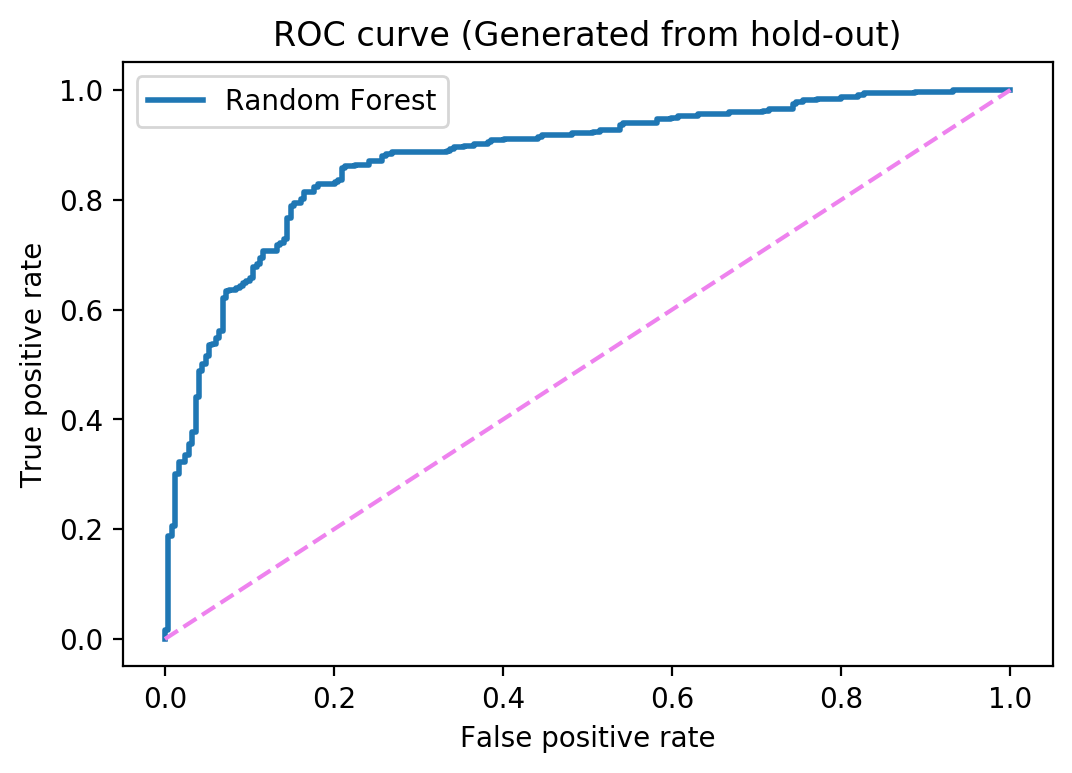

In [126]:
drugslib.rand_forestCV(X2,y2)

## Pair Plot 02

In [127]:
ax1 = sns.pairplot(data02, hue = 'user', diag_kind='kde')
ax1.savefig('pairplot_itr_02.png');

/Users/AKE/opt/anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/AKE/opt/anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


Error in callback <function flush_figures at 0x2f24386950> (for post_execute):


KeyboardInterrupt: 

## Save Itr 02 Dataset to CSV

In [128]:
# Merging X2 with y2 and saving to new CSV
data02_used = pd.merge(X2, y2, left_index = True, right_index = True)

# Save out new CSV for reference.
data02_used.to_csv('drugs_all_data_02.csv')

# Iteration 03

## Load Data

In [129]:
data03 = pd.read_csv('drugs_all_data_02.csv', index_col=0)

## Swap Standardized for Actual Scores

**Replacing Normative Values with Actual Values**  

### Neuroticism

In [130]:
# Define replacement dictionary
neurot_score = list(range(12,61))

In [131]:
drugslib.new_val_and_replace(data03, 'neuroticism', neurot_score)

New neuroticism values:
 [39. 29. 31. 34. 43. 24. 42. 33. 26. 56. 28. 27. 19. 22. 41. 49. 32. 25.
 40. 51. 35. 36. 46. 44. 37. 47. 23. 30. 38. 18. 45. 17. 53. 50. 60. 21.
 54. 59. 48. 20. 55. 16. 57. 52. 58. 14. 15. 13. 12.]

Description:
 count    1882.0000
mean       35.9293
std         9.1408
min        12.0000
25%        29.0000
50%        36.0000
75%        42.0000
max        60.0000
Name: neuroticism, dtype: float64


,age,gender,neuroticism,extraversion,openness_to_experience,agreeableness,conscientiousness,impulsivity,sensation_seeking,gdp_pc,Black,Mixed-Black/White,Other_Ethnicity,White,edu_vs_exp,edu_vs_mean,age_vs_exp,big5,user
0,35.0,0.0,39.0,-0.5755,-0.5833,-0.9170,-0.0066,-0.2171,-1.1808,39532.0,0,0,0,0,1.2270,1.5038,0.4217,-0.0477,0
1,25.0,1.0,29.0,1.9389,1.4353,0.7610,-0.1428,-0.7113,-0.2157,39532.0,0,0,0,1,1.6564,2.0301,0.3145,-0.0273,1
2,35.0,1.0,31.0,0.8052,-0.8473,-1.6209,-1.0145,-1.3798,0.4015,39532.0,0,0,0,1,1.2270,1.5038,0.4403,-0.2699,0
3,18.0,0.0,34.0,-0.8062,-0.0193,0.5904,0.5849,-1.3798,-1.1808,39532.0,0,0,0,1,1.4110,1.7293,0.2169,-0.1468,1
4,35.0,0.0,43.0,-1.6334,-0.4517,-0.3017,1.3061,-0.2171,-0.2157,39532.0,0,0,0,1,1.6564,2.0301,0.4217,-0.0041,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1877,18.0,0.0,25.0,1.7409,1.8851,0.7610,-1.1379,0.8811,1.9217,59939.0,0,0,0,1,1.1515,1.4394,0.2211,0.2072,1
1878,18.0,1.0,33.0,1.7409,0.5833,0.7610,-1.5184,0.8811,0.7654,59939.0,0,0,0,1,1.1515,1.4394,0.2359,0.4813,1
1879,25.0,0.0,47.0,-1.3764,-1.2755,-1.7720,-1.3850,0.5298,-0.5259,59939.0,0,0,0,1,1.2727,1.5909,0.3071,-0.0059,1
1880,18.0,0.0,45.0,-1.9217,0.2934,-1.6209,-2.5731,1.2922,1.2247,59939.0,0,0,0,1,1.1515,1.4394,0.2211,0.2412,1


### Extroversion

In [132]:
# Escore
escore_list = [
    16, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 
    36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 
    55, 56, 58, 59
]

In [133]:
drugslib.new_val_and_replace(data03, 'extraversion', escore_list)

New extraversion values:
 [36. 52. 45. 34. 28. 38. 32. 55. 40. 41. 49. 29. 31. 39. 27. 43. 33. 16.
 44. 37. 51. 42. 48. 46. 47. 35. 50. 30. 26. 58. 53. 54. 23. 22. 24. 19.
 20. 21. 25. 56. 59. 18.]

Description:
 count    1882.0000
mean       39.5701
std         6.7697
min        16.0000
25%        35.0000
50%        40.0000
75%        44.0000
max        59.0000
Name: extraversion, dtype: float64


,age,gender,neuroticism,extraversion,openness_to_experience,agreeableness,conscientiousness,impulsivity,sensation_seeking,gdp_pc,Black,Mixed-Black/White,Other_Ethnicity,White,edu_vs_exp,edu_vs_mean,age_vs_exp,big5,user
0,35.0,0.0,39.0,36.0,-0.5833,-0.9170,-0.0066,-0.2171,-1.1808,39532.0,0,0,0,0,1.2270,1.5038,0.4217,-0.0477,0
1,25.0,1.0,29.0,52.0,1.4353,0.7610,-0.1428,-0.7113,-0.2157,39532.0,0,0,0,1,1.6564,2.0301,0.3145,-0.0273,1
2,35.0,1.0,31.0,45.0,-0.8473,-1.6209,-1.0145,-1.3798,0.4015,39532.0,0,0,0,1,1.2270,1.5038,0.4403,-0.2699,0
3,18.0,0.0,34.0,34.0,-0.0193,0.5904,0.5849,-1.3798,-1.1808,39532.0,0,0,0,1,1.4110,1.7293,0.2169,-0.1468,1
4,35.0,0.0,43.0,28.0,-0.4517,-0.3017,1.3061,-0.2171,-0.2157,39532.0,0,0,0,1,1.6564,2.0301,0.4217,-0.0041,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1877,18.0,0.0,25.0,51.0,1.8851,0.7610,-1.1379,0.8811,1.9217,59939.0,0,0,0,1,1.1515,1.4394,0.2211,0.2072,1
1878,18.0,1.0,33.0,51.0,0.5833,0.7610,-1.5184,0.8811,0.7654,59939.0,0,0,0,1,1.1515,1.4394,0.2359,0.4813,1
1879,25.0,0.0,47.0,30.0,-1.2755,-1.7720,-1.3850,0.5298,-0.5259,59939.0,0,0,0,1,1.2727,1.5909,0.3071,-0.0059,1
1880,18.0,0.0,45.0,26.0,0.2934,-1.6209,-2.5731,1.2922,1.2247,59939.0,0,0,0,1,1.1515,1.4394,0.2211,0.2412,1


### Openness to New Experiences

In [134]:
# Openness
print(list(range(24,61)))
oscore = [
    24, 26, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 
    40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 
    56, 57, 58, 59, 60
]

[24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60]


In [135]:
drugslib.new_val_and_replace(data03, 'openness_to_experience', oscore)

New openness_to_experience values:
 [42. 55. 40. 46. 43. 35. 39. 36. 38. 47. 49. 34. 44. 45. 29. 51. 37. 54.
 24. 41. 52. 48. 28. 53. 32. 33. 26. 31. 50. 58. 30. 56. 57. 60. 59.]

Description:
 count    1882.0000
mean       45.7630
std         6.5805
min        24.0000
25%        41.0000
50%        46.0000
75%        51.0000
max        60.0000
Name: openness_to_experience, dtype: float64


,age,gender,neuroticism,extraversion,openness_to_experience,agreeableness,conscientiousness,impulsivity,sensation_seeking,gdp_pc,Black,Mixed-Black/White,Other_Ethnicity,White,edu_vs_exp,edu_vs_mean,age_vs_exp,big5,user
0,35.0,0.0,39.0,36.0,42.0,-0.9170,-0.0066,-0.2171,-1.1808,39532.0,0,0,0,0,1.2270,1.5038,0.4217,-0.0477,0
1,25.0,1.0,29.0,52.0,55.0,0.7610,-0.1428,-0.7113,-0.2157,39532.0,0,0,0,1,1.6564,2.0301,0.3145,-0.0273,1
2,35.0,1.0,31.0,45.0,40.0,-1.6209,-1.0145,-1.3798,0.4015,39532.0,0,0,0,1,1.2270,1.5038,0.4403,-0.2699,0
3,18.0,0.0,34.0,34.0,46.0,0.5904,0.5849,-1.3798,-1.1808,39532.0,0,0,0,1,1.4110,1.7293,0.2169,-0.1468,1
4,35.0,0.0,43.0,28.0,43.0,-0.3017,1.3061,-0.2171,-0.2157,39532.0,0,0,0,1,1.6564,2.0301,0.4217,-0.0041,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1877,18.0,0.0,25.0,51.0,57.0,0.7610,-1.1379,0.8811,1.9217,59939.0,0,0,0,1,1.1515,1.4394,0.2211,0.2072,1
1878,18.0,1.0,33.0,51.0,50.0,0.7610,-1.5184,0.8811,0.7654,59939.0,0,0,0,1,1.1515,1.4394,0.2359,0.4813,1
1879,25.0,0.0,47.0,30.0,37.0,-1.7720,-1.3850,0.5298,-0.5259,59939.0,0,0,0,1,1.2727,1.5909,0.3071,-0.0059,1
1880,18.0,0.0,45.0,26.0,48.0,-1.6209,-2.5731,1.2922,1.2247,59939.0,0,0,0,1,1.1515,1.4394,0.2211,0.2412,1


### Agreeableness

In [136]:
# agreeableness
ascore = [
    12, 16, 18, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 
    40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60
]


In [137]:
drugslib.new_val_and_replace(data03, 'agreeableness', ascore)

New agreeableness values:
 [37. 48. 32. 47. 41. 55. 38. 30. 49. 39. 36. 45. 40. 53. 50. 43. 33. 46.
 51. 23. 44. 29. 54. 42. 35. 34. 52. 31. 57. 56. 27. 25. 28. 58. 26. 59.
 24. 18. 12. 16. 60.]

Description:
 count    1882.0000
mean       42.8640
std         6.4339
min        12.0000
25%        39.0000
50%        43.0000
75%        48.0000
max        60.0000
Name: agreeableness, dtype: float64


,age,gender,neuroticism,extraversion,openness_to_experience,agreeableness,conscientiousness,impulsivity,sensation_seeking,gdp_pc,Black,Mixed-Black/White,Other_Ethnicity,White,edu_vs_exp,edu_vs_mean,age_vs_exp,big5,user
0,35.0,0.0,39.0,36.0,42.0,37.0,-0.0066,-0.2171,-1.1808,39532.0,0,0,0,0,1.2270,1.5038,0.4217,-0.0477,0
1,25.0,1.0,29.0,52.0,55.0,48.0,-0.1428,-0.7113,-0.2157,39532.0,0,0,0,1,1.6564,2.0301,0.3145,-0.0273,1
2,35.0,1.0,31.0,45.0,40.0,32.0,-1.0145,-1.3798,0.4015,39532.0,0,0,0,1,1.2270,1.5038,0.4403,-0.2699,0
3,18.0,0.0,34.0,34.0,46.0,47.0,0.5849,-1.3798,-1.1808,39532.0,0,0,0,1,1.4110,1.7293,0.2169,-0.1468,1
4,35.0,0.0,43.0,28.0,43.0,41.0,1.3061,-0.2171,-0.2157,39532.0,0,0,0,1,1.6564,2.0301,0.4217,-0.0041,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1877,18.0,0.0,25.0,51.0,57.0,48.0,-1.1379,0.8811,1.9217,59939.0,0,0,0,1,1.1515,1.4394,0.2211,0.2072,1
1878,18.0,1.0,33.0,51.0,50.0,48.0,-1.5184,0.8811,0.7654,59939.0,0,0,0,1,1.1515,1.4394,0.2359,0.4813,1
1879,25.0,0.0,47.0,30.0,37.0,31.0,-1.3850,0.5298,-0.5259,59939.0,0,0,0,1,1.2727,1.5909,0.3071,-0.0059,1
1880,18.0,0.0,45.0,26.0,48.0,32.0,-2.5731,1.2922,1.2247,59939.0,0,0,0,1,1.1515,1.4394,0.2211,0.2412,1


### Conscientiousness

In [138]:
# conscientiousness
cscore = [
    17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 
    40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 59
]


In [139]:
drugslib.new_val_and_replace(data03, 'conscientiousness', cscore)

New conscientiousness values:
 [42. 41. 34. 46. 50. 52. 48. 49. 43. 53. 38. 36. 59. 47. 31. 30. 33. 35.
 51. 25. 37. 45. 39. 44. 27. 40. 29. 54. 55. 32. 56. 20. 28. 26. 22. 24.
 23. 19. 17. 21. 57.]

Description:
 count    1882.0000
mean       41.4368
std         6.9586
min        17.0000
25%        37.0000
50%        42.0000
75%        46.0000
max        59.0000
Name: conscientiousness, dtype: float64


,age,gender,neuroticism,extraversion,openness_to_experience,agreeableness,conscientiousness,impulsivity,sensation_seeking,gdp_pc,Black,Mixed-Black/White,Other_Ethnicity,White,edu_vs_exp,edu_vs_mean,age_vs_exp,big5,user
0,35.0,0.0,39.0,36.0,42.0,37.0,42.0,-0.2171,-1.1808,39532.0,0,0,0,0,1.2270,1.5038,0.4217,-0.0477,0
1,25.0,1.0,29.0,52.0,55.0,48.0,41.0,-0.7113,-0.2157,39532.0,0,0,0,1,1.6564,2.0301,0.3145,-0.0273,1
2,35.0,1.0,31.0,45.0,40.0,32.0,34.0,-1.3798,0.4015,39532.0,0,0,0,1,1.2270,1.5038,0.4403,-0.2699,0
3,18.0,0.0,34.0,34.0,46.0,47.0,46.0,-1.3798,-1.1808,39532.0,0,0,0,1,1.4110,1.7293,0.2169,-0.1468,1
4,35.0,0.0,43.0,28.0,43.0,41.0,50.0,-0.2171,-0.2157,39532.0,0,0,0,1,1.6564,2.0301,0.4217,-0.0041,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1877,18.0,0.0,25.0,51.0,57.0,48.0,33.0,0.8811,1.9217,59939.0,0,0,0,1,1.1515,1.4394,0.2211,0.2072,1
1878,18.0,1.0,33.0,51.0,50.0,48.0,30.0,0.8811,0.7654,59939.0,0,0,0,1,1.1515,1.4394,0.2359,0.4813,1
1879,25.0,0.0,47.0,30.0,37.0,31.0,31.0,0.5298,-0.5259,59939.0,0,0,0,1,1.2727,1.5909,0.3071,-0.0059,1
1880,18.0,0.0,45.0,26.0,48.0,32.0,22.0,1.2922,1.2247,59939.0,0,0,0,1,1.1515,1.4394,0.2211,0.2412,1


### Impulsiveness and Sensation Seeking

These two categories were not replaced with scores because no values were provided in the reference tables. 

## Defining Iteration 03 Data

In [140]:
# Columns that are commented out are kept in the model

X3 = data03.drop(['user',
#                   'age', 
#                   'gender', 
#                   'neuroticism', 
#                   'extraversion',
#                   'openness_to_experience', 
#                   'agreeableness', 
#                   'conscientiousness',
#                   'impulsivity', 
#                   'sensation_seeking', 
#                   'gdp_pc', 
#                   'Black',

#                   'Mixed-Black/White', 

#                   'Other_Ethnicity', 
#                   'White', 
#                   'edu_vs_exp', 
#                   'edu_vs_mean', 
#                   'age_vs_exp',
#                   'big5'
                 ], axis = 1)

y3 = data03.user

## Random Forest CV 03

Same as iteration 2 but with actual scores instead of standardized scores. 


Features sorted by their score for estimator 0:

                        importance
gdp_pc                      0.2834
big5                        0.1735
sensation_seeking           0.1144
age_vs_exp                  0.0734
age                         0.0621
edu_vs_exp                  0.0608
openness_to_experience      0.0570
conscientiousness           0.0476
edu_vs_mean                 0.0330
impulsivity                 0.0237
neuroticism                 0.0228
extraversion                0.0182
agreeableness               0.0156
gender                      0.0124
White                       0.0015
Other_Ethnicity             0.0005
Black                       0.0000
Mixed-Black/White           0.0000



Features sorted by their score for estimator 1:

                        importance
gdp_pc                      0.2901
big5                        0.1576
age_vs_exp                  0.0940
sensation_seeking           0.0899
age                         0.0837
edu_vs_exp             

,Random_ForestCV
Accuracy (train),0.8546
Accuracy (test),0.8086
Accuracy (diff),0.0460
Precision,0.8725
Recall,0.8623
F1,0.8673
AUC,0.9320


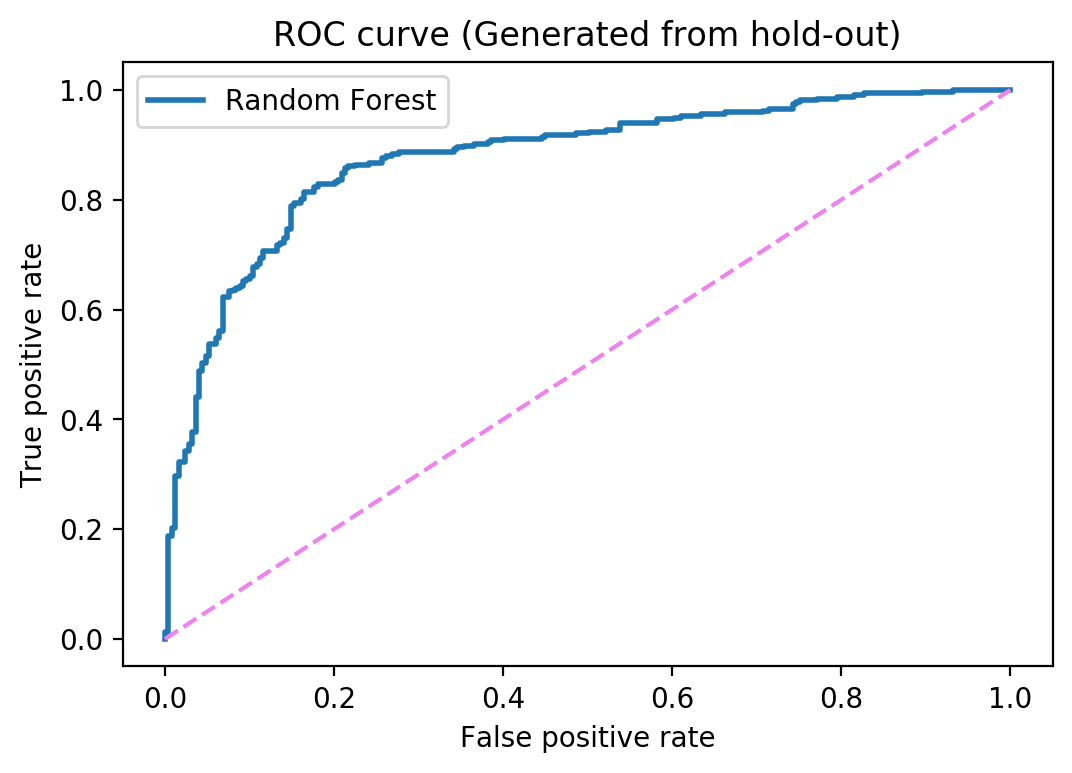

In [141]:
drugslib.rand_forestCV(X3,y3)

## Assessment

Overfitting decreased with use of actual score data in Random Forest Classifier.  Other metrics relatively unchanged. 

In [142]:
ax1 = sns.pairplot(data03, hue = 'user', diag_kind='kde')
ax1.savefig('pairplot_itr_03.png');

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x2f24386950> (for post_execute):


KeyboardInterrupt: 

## Save Itr 03 Dataset to CSV

In [143]:
# Merging X3 with y3 and saving to new CSV
data03_used = pd.merge(X3, y3, left_index = True, right_index = True)

# Save out new CSV for reference.
data03_used.to_csv('drugs_all_data_03.csv')

# Iteration 04

## Load Data

In [144]:
data04 = pd.read_csv('drugs_all_data_03.csv', index_col=0)

## Feature Engineering

**Columns that will be added this iteration**  

**ne_c = (N)(E)(sen)/(C)**  because high N, E and low C are highly correlated with hazardous health behaviors and sensation seeking has been found to be high for recreational drug users. 

**n_ac = (N)/(A)(C)**  because high N and low A and C has been associated with higher rate of drug use. 

**no_ = (N)(O)**  because high scores in these categories have been linked to higher rates of drug use. 

**gdpedu_c = (gdp_pc)(edu_vs_exp)/(C)** because individuals with higher socioeconomic status paired with low C is correlated to illicit drug use.  gdp*edu will be used to simulate socioeconomic status (higher edu in country with higher gdp). 


In [145]:
data04.columns

Index(['age', 'gender', 'neuroticism', 'extraversion',
       'openness_to_experience', 'agreeableness', 'conscientiousness',
       'impulsivity', 'sensation_seeking', 'gdp_pc', 'Black',
       'Mixed-Black/White', 'Other_Ethnicity', 'White', 'edu_vs_exp',
       'edu_vs_mean', 'age_vs_exp', 'big5', 'user'],
      dtype='object')

### Adding nes_c

Neuroticism/its mean for non-users makes users have a value of > 1 which is multiplied by the extraversion score.This aspect of the equation should be larger for users.  

The conscientiousness score is divided by its mean for users so users will have a value < 1.  This is squared, further decreasing the value if you fall below the mean of C.  It is multiplied by an arbitrary 85 and subtracted from the neuroticism score above. 

In [146]:
data04['nes_c'] = ((((data04['neuroticism']/data04['neuroticism'].loc[(data04['user']==0)].mean())) * (data04['extraversion']) * 2*(data04['sensation_seeking'])) - 85*((data04['conscientiousness']/(data04['conscientiousness'].loc[(data04['user']==1)].mean()))**2))

print(f"Neuroticism:")
print(f"Non-user: {data04['neuroticism'].loc[(data04['user']==0)].mean()}")
print(f"User: {data04['neuroticism'].loc[(data04['user']==1)].mean()}\n")
      
print(f"Conscientiousness:")
print(f"Non-user: {data04['conscientiousness'].loc[(data04['user']==0)].mean()}")
print(f"User: {data04['conscientiousness'].loc[(data04['user']==1)].mean()}\n")

print(f"sensation_seeking:")
print(f"Non-user: {data04['sensation_seeking'].loc[(data04['user']==0)].mean()}")
print(f"User: {data04['sensation_seeking'].loc[(data04['user']==1)].mean()}\n")
      
print(f"{data04['nes_c'].describe()}\n")
print(f"Std dev btw user and non-user means:\n {abs((data04['nes_c'].loc[(data04['user']==0)].mean() - data04['nes_c'].loc[(data04['user']==1)].mean())/data04['nes_c'].std())}")
data04.head()

Neuroticism:
Non-user: 34.042857142857144
User: 37.450095969289826

Conscientiousness:
Non-user: 43.77738095238095
User: 39.549904030710174

sensation_seeking:
Non-user: -0.47829192857142855
User: 0.37790266794625715

count    1882.0000
mean      -91.7641
std        93.7723
min      -360.6720
25%      -156.3008
50%       -96.1841
75%       -29.2601
max       241.9062
Name: nes_c, dtype: float64

Std dev btw user and non-user means:
 0.943467065584071


,age,gender,neuroticism,extraversion,openness_to_experience,agreeableness,conscientiousness,impulsivity,sensation_seeking,gdp_pc,Black,Mixed-Black/White,Other_Ethnicity,White,edu_vs_exp,edu_vs_mean,age_vs_exp,big5,user,nes_c
0,35.0,0.0,39.0,36.0,42.0,37.0,42.0,-0.2171,-1.1808,39532.0,0,0,0,0,1.2270,1.5038,0.4217,-0.0477,0,-193.2583
1,25.0,1.0,29.0,52.0,55.0,48.0,41.0,-0.7113,-0.2157,39532.0,0,0,0,1,1.6564,2.0301,0.3145,-0.0273,1,-110.4615
2,35.0,1.0,31.0,45.0,40.0,32.0,34.0,-1.3798,0.4015,39532.0,0,0,0,1,1.2270,1.5038,0.4403,-0.2699,0,-29.9148
3,18.0,0.0,34.0,34.0,46.0,47.0,46.0,-1.3798,-1.1808,39532.0,0,0,0,1,1.4110,1.7293,0.2169,-0.1468,1,-195.1817
4,35.0,0.0,43.0,28.0,43.0,41.0,50.0,-0.2171,-0.2157,39532.0,0,0,0,1,1.6564,2.0301,0.4217,-0.0041,0,-151.1136


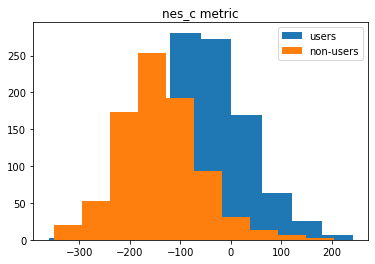

In [147]:
plt.hist(data04.nes_c[data04['user']==1], label = 'users')
plt.hist(data04.nes_c[data04['user']==0], label = 'non-users')
plt.title('nes_c metric')
plt.legend();

### Adding n_ac

In [148]:
data04['n_ac'] = ( data04['neuroticism'] /  
                    (data04['conscientiousness'] * data04['agreeableness'] )
                 )

print(f"Neuroticism:")
print(f"Non-user: {data04['neuroticism'].loc[(data04['user']==0)].mean()}")
print(f"User: {data04['neuroticism'].loc[(data04['user']==1)].mean()}\n")
      
print(f"Conscientiousness:")
print(f"Non-user: {data04['conscientiousness'].loc[(data04['user']==0)].mean()}")
print(f"User: {data04['conscientiousness'].loc[(data04['user']==1)].mean()}\n")
      
print(f"Agreeableness:")
print(f"Non-user: {data04['agreeableness'].loc[(data04['user']==0)].mean()}")
print(f"User: {data04['agreeableness'].loc[(data04['user']==1)].mean()}\n")
      
print(f"{data04['n_ac'].describe()}\n")
print(f"Std dev btw user and non-user means:\n {abs((data04['n_ac'].loc[(data04['user']==0)].mean() - data04['n_ac'].loc[(data04['user']==1)].mean())/data04['n_ac'].std())}")
data04.head()

Neuroticism:
Non-user: 34.042857142857144
User: 37.450095969289826

Conscientiousness:
Non-user: 43.77738095238095
User: 39.549904030710174

Agreeableness:
Non-user: 44.12619047619047
User: 41.84644913627639

count    1882.0000
mean        0.0222
std         0.0110
min         0.0044
25%         0.0148
50%         0.0198
75%         0.0267
max         0.1077
Name: n_ac, dtype: float64

Std dev btw user and non-user means:
 0.5647854902638575


,age,gender,neuroticism,extraversion,openness_to_experience,agreeableness,conscientiousness,impulsivity,sensation_seeking,gdp_pc,...,Mixed-Black/White,Other_Ethnicity,White,edu_vs_exp,edu_vs_mean,age_vs_exp,big5,user,nes_c,n_ac
0,35.0,0.0,39.0,36.0,42.0,37.0,42.0,-0.2171,-1.1808,39532.0,...,0,0,0,1.2270,1.5038,0.4217,-0.0477,0,-193.2583,0.0251
1,25.0,1.0,29.0,52.0,55.0,48.0,41.0,-0.7113,-0.2157,39532.0,...,0,0,1,1.6564,2.0301,0.3145,-0.0273,1,-110.4615,0.0147
2,35.0,1.0,31.0,45.0,40.0,32.0,34.0,-1.3798,0.4015,39532.0,...,0,0,1,1.2270,1.5038,0.4403,-0.2699,0,-29.9148,0.0285
3,18.0,0.0,34.0,34.0,46.0,47.0,46.0,-1.3798,-1.1808,39532.0,...,0,0,1,1.4110,1.7293,0.2169,-0.1468,1,-195.1817,0.0157
4,35.0,0.0,43.0,28.0,43.0,41.0,50.0,-0.2171,-0.2157,39532.0,...,0,0,1,1.6564,2.0301,0.4217,-0.0041,0,-151.1136,0.0210


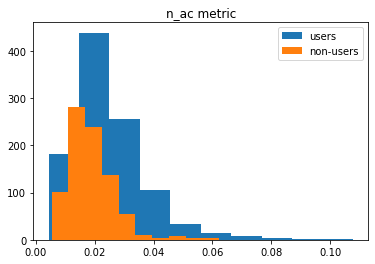

In [149]:
plt.hist(data04.n_ac[data04['user']==1], label = 'users')
plt.hist(data04.n_ac[data04['user']==0], label = 'non-users')
plt.title('n_ac metric')
plt.legend();

### Adding no_

In [150]:
data04['no_'] = ( data04['neuroticism'] * data04['openness_to_experience']
                 )

print(f"Neuroticism:")
print(f"Non-user: {data04['neuroticism'].loc[(data04['user']==0)].mean()}")
print(f"User: {data04['neuroticism'].loc[(data04['user']==1)].mean()}\n")
      
print(f"openness_to_experience:")
print(f"Non-user: {data04['openness_to_experience'].loc[(data04['user']==0)].mean()}")
print(f"User: {data04['openness_to_experience'].loc[(data04['user']==1)].mean()}\n")

      
print(f"{data04['no_'].describe()}\n")
print(f"Std dev btw user and non-user means:\n {abs((data04['no_'].loc[(data04['user']==0)].mean() - data04['no_'].loc[(data04['user']==1)].mean())/data04['no_'].std())}")
data04.head()

Neuroticism:
Non-user: 34.042857142857144
User: 37.450095969289826

openness_to_experience:
Non-user: 43.18928571428572
User: 47.83781190019194

count    1882.0000
mean     1645.2465
std       490.5256
min       480.0000
25%      1274.2500
50%      1596.0000
75%      1976.0000
max      3245.0000
Name: no_, dtype: float64

Std dev btw user and non-user means:
 0.642610958951108


,age,gender,neuroticism,extraversion,openness_to_experience,agreeableness,conscientiousness,impulsivity,sensation_seeking,gdp_pc,...,Other_Ethnicity,White,edu_vs_exp,edu_vs_mean,age_vs_exp,big5,user,nes_c,n_ac,no_
0,35.0,0.0,39.0,36.0,42.0,37.0,42.0,-0.2171,-1.1808,39532.0,...,0,0,1.2270,1.5038,0.4217,-0.0477,0,-193.2583,0.0251,1638.0
1,25.0,1.0,29.0,52.0,55.0,48.0,41.0,-0.7113,-0.2157,39532.0,...,0,1,1.6564,2.0301,0.3145,-0.0273,1,-110.4615,0.0147,1595.0
2,35.0,1.0,31.0,45.0,40.0,32.0,34.0,-1.3798,0.4015,39532.0,...,0,1,1.2270,1.5038,0.4403,-0.2699,0,-29.9148,0.0285,1240.0
3,18.0,0.0,34.0,34.0,46.0,47.0,46.0,-1.3798,-1.1808,39532.0,...,0,1,1.4110,1.7293,0.2169,-0.1468,1,-195.1817,0.0157,1564.0
4,35.0,0.0,43.0,28.0,43.0,41.0,50.0,-0.2171,-0.2157,39532.0,...,0,1,1.6564,2.0301,0.4217,-0.0041,0,-151.1136,0.0210,1849.0


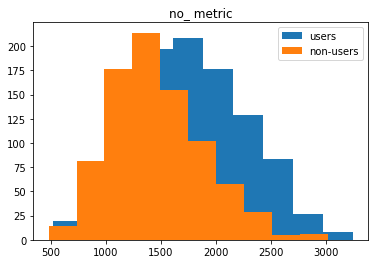

In [151]:
plt.hist(data04.no_[data04['user']==1], label = 'users')
plt.hist(data04.no_[data04['user']==0], label = 'non-users')
plt.title('no_ metric')
plt.legend();

### Adding gdp_educ

In [152]:
data04['gdp_educ'] = ( (data04['gdp_pc'] ) /  
                    ((data04['conscientiousness']))
                  )

print(f"GDP per capita:")
print(f"Non-user: {data04['gdp_pc'].loc[(data04['user']==0)].mean()}")
print(f"User: {data04['gdp_pc'].loc[(data04['user']==1)].mean()}\n")
      
print(f"edu_vs_mean:")
print(f"Non-user: {data04['edu_vs_mean'].loc[(data04['user']==0)].mean()}")
print(f"User: {data04['edu_vs_mean'].loc[(data04['user']==1)].mean()}\n")
      
print(f"Conscientiousness:")
print(f"Non-user: {data04['conscientiousness'].loc[(data04['user']==0)].mean()}")
print(f"User: {data04['conscientiousness'].loc[(data04['user']==1)].mean()}\n")
      
print(f"{data04['gdp_educ'].describe()}\n")
print(f"Std dev btw user and non-user means:\n {abs((data04['gdp_educ'].loc[(data04['user']==0)].mean() - data04['gdp_educ'].loc[(data04['user']==1)].mean())/data04['gdp_educ'].std())}")
data04.head()

GDP per capita:
Non-user: 41530.6012719972
User: 51406.47656165986

edu_vs_mean:
Non-user: 1.5736822150344951
User: 1.504295846024527

Conscientiousness:
Non-user: 43.77738095238095
User: 39.549904030710174

count    1882.0000
mean     1180.9169
std       372.2147
min       693.5439
25%       878.4889
50%      1068.4324
75%      1393.9302
max      3154.6842
Name: gdp_educ, dtype: float64

Std dev btw user and non-user means:
 1.0098203171050362


,age,gender,neuroticism,extraversion,openness_to_experience,agreeableness,conscientiousness,impulsivity,sensation_seeking,gdp_pc,...,White,edu_vs_exp,edu_vs_mean,age_vs_exp,big5,user,nes_c,n_ac,no_,gdp_educ
0,35.0,0.0,39.0,36.0,42.0,37.0,42.0,-0.2171,-1.1808,39532.0,...,0,1.2270,1.5038,0.4217,-0.0477,0,-193.2583,0.0251,1638.0,941.2381
1,25.0,1.0,29.0,52.0,55.0,48.0,41.0,-0.7113,-0.2157,39532.0,...,1,1.6564,2.0301,0.3145,-0.0273,1,-110.4615,0.0147,1595.0,964.1951
2,35.0,1.0,31.0,45.0,40.0,32.0,34.0,-1.3798,0.4015,39532.0,...,1,1.2270,1.5038,0.4403,-0.2699,0,-29.9148,0.0285,1240.0,1162.7059
3,18.0,0.0,34.0,34.0,46.0,47.0,46.0,-1.3798,-1.1808,39532.0,...,1,1.4110,1.7293,0.2169,-0.1468,1,-195.1817,0.0157,1564.0,859.3913
4,35.0,0.0,43.0,28.0,43.0,41.0,50.0,-0.2171,-0.2157,39532.0,...,1,1.6564,2.0301,0.4217,-0.0041,0,-151.1136,0.0210,1849.0,790.6400


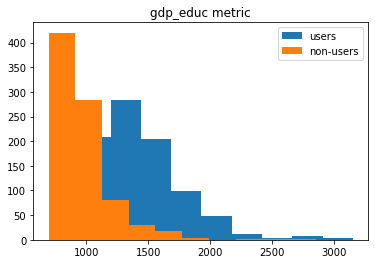

In [153]:
plt.hist(data04.gdp_educ[data04['user']==1], label = 'users')
plt.hist(data04.gdp_educ[data04['user']==0], label = 'non-users')
plt.title('gdp_educ metric')
plt.legend();

## Defining Iteration 04 Data

In [154]:
data04.columns

Index(['age', 'gender', 'neuroticism', 'extraversion',
       'openness_to_experience', 'agreeableness', 'conscientiousness',
       'impulsivity', 'sensation_seeking', 'gdp_pc', 'Black',
       'Mixed-Black/White', 'Other_Ethnicity', 'White', 'edu_vs_exp',
       'edu_vs_mean', 'age_vs_exp', 'big5', 'user', 'nes_c', 'n_ac', 'no_',
       'gdp_educ'],
      dtype='object')

In [155]:
X4 = data04.drop([
    'age', 
    'gender', 
#     'neuroticism', 
    'extraversion',
    'openness_to_experience', 
#     'agreeableness', 
#     'conscientiousness',
#     'impulsivity', 
#     'sensation_seeking', 
    'gdp_pc', 
    'Black',
    'Mixed-Black/White', 
    'Other_Ethnicity', 
    'White', 
#     'edu_vs_exp',
#     'edu_vs_mean', 
#      'age_vs_exp', 
#      'big5', 
    'user', 
#     'nes_c', 
#     'n_ac', 
#     'no_',
#     'gdp_educ'
], axis =1)

y4 = data04.user

## Random Forest CV 04


Features sorted by their score for estimator 0:

                   importance
gdp_educ               0.2502
big5                   0.1849
nes_c                  0.1160
sensation_seeking      0.1046
age_vs_exp             0.0698
edu_vs_exp             0.0696
no_                    0.0495
edu_vs_mean            0.0485
n_ac                   0.0300
impulsivity            0.0260
neuroticism            0.0210
conscientiousness      0.0184
agreeableness          0.0114



Features sorted by their score for estimator 1:

                   importance
gdp_educ               0.2507
big5                   0.1718
nes_c                  0.1200
edu_vs_exp             0.0919
sensation_seeking      0.0918
age_vs_exp             0.0794
edu_vs_mean            0.0627
no_                    0.0392
neuroticism            0.0211
impulsivity            0.0202
n_ac                   0.0192
conscientiousness      0.0191
agreeableness          0.0129



Features sorted by their score for estimator 2:

      

,Random_ForestCV
Accuracy (train),0.8538
Accuracy (test),0.8064
Accuracy (diff),0.0475
Precision,0.8672
Recall,0.8678
F1,0.8675
AUC,0.9296


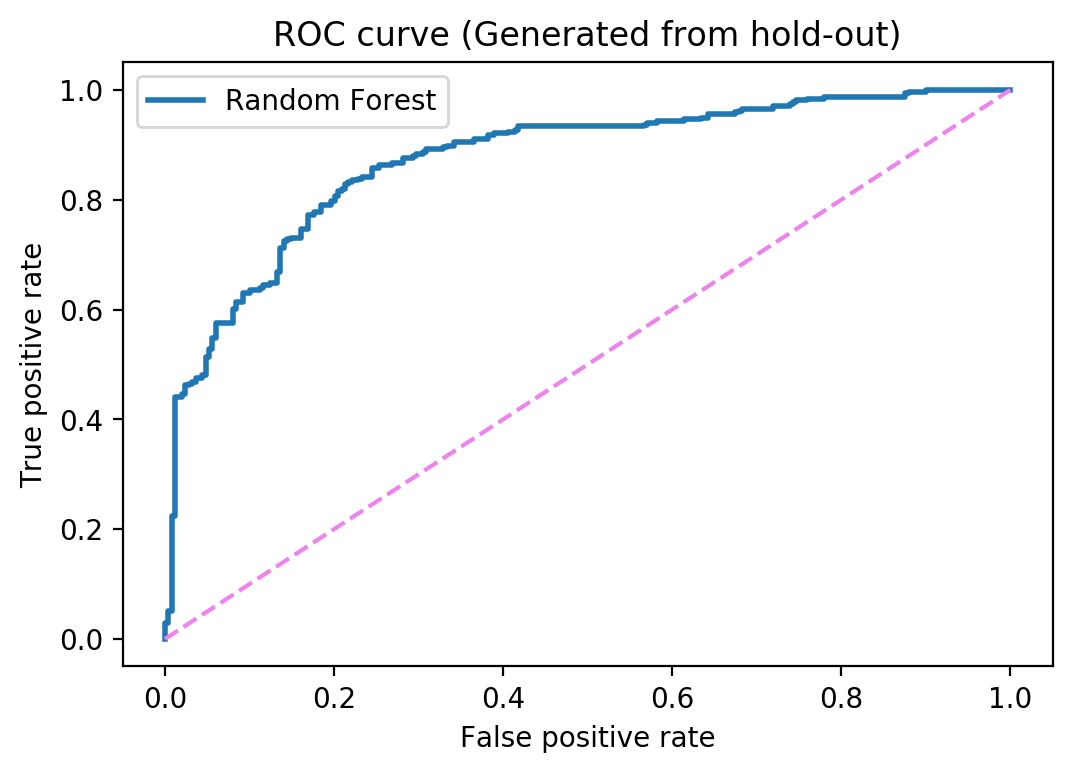

In [156]:
drugslib.rand_forestCV(X4,y4)

## Assessment

In [157]:
ax1 = sns.pairplot(data04, hue = 'user', diag_kind='kde')
ax1.savefig('pairplot_itr_04.png');

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x2f24386950> (for post_execute):


KeyboardInterrupt: 

## Save Itr 04 Dataset to CSV

In [158]:
# Merging X4 with y4 and saving to new CSV
data04_used = pd.merge(X4, y4, left_index = True, right_index = True)

# Save out new CSV for reference.
data04_used.to_csv('drugs_all_data_04.csv')

# Grid Search

In [ ]:
rf_param = {'bootstrap': [True], 
            'class_weight': [None], 
            'criterion': ['gini', 'entropy'],
            'max_depth':np.arange(3,10,1), 
            'max_features':['auto', None], 
            'max_leaf_nodes':[None],
            'min_impurity_decrease':[0.0], 
            'min_impurity_split':[None],
            'min_samples_leaf':np.arange(2,10,1), 
            'min_samples_split':np.arange(2,10,1),
            'min_weight_fraction_leaf':[0.0], 
            'n_estimators':np.arange(30,100,10),
            'n_jobs':[None], 
            'oob_score':[True,False], 
            'random_state':[9],
            'verbose':[0], 
            'warm_start':[False]
            }

clf = GridSearchCV(estimator = RandomForestClassifier(), param_grid = rf_param)
                  
scores = clf.fit(X4,y4)

In [ ]:
scores.cv_results_

In [ ]:
scores.best_score_

In [ ]:
scores.best_estimator_


In [ ]:
scores.best_params_



Features sorted by their score for estimator 0:

                   importance
gdp_educ               0.2502
big5                   0.1849
nes_c                  0.1160
sensation_seeking      0.1046
age_vs_exp             0.0698
edu_vs_exp             0.0696
no_                    0.0495
edu_vs_mean            0.0485
n_ac                   0.0300
impulsivity            0.0260
neuroticism            0.0210
conscientiousness      0.0184
agreeableness          0.0114



Features sorted by their score for estimator 1:

                   importance
gdp_educ               0.2507
big5                   0.1718
nes_c                  0.1200
edu_vs_exp             0.0919
sensation_seeking      0.0918
age_vs_exp             0.0794
edu_vs_mean            0.0627
no_                    0.0392
neuroticism            0.0211
impulsivity            0.0202
n_ac                   0.0192
conscientiousness      0.0191
agreeableness          0.0129



Features sorted by their score for estimator 2:

      

,Random_ForestCV
Accuracy (train),0.8538
Accuracy (test),0.8064
Accuracy (diff),0.0475
Precision,0.8672
Recall,0.8678
F1,0.8675
AUC,0.9296


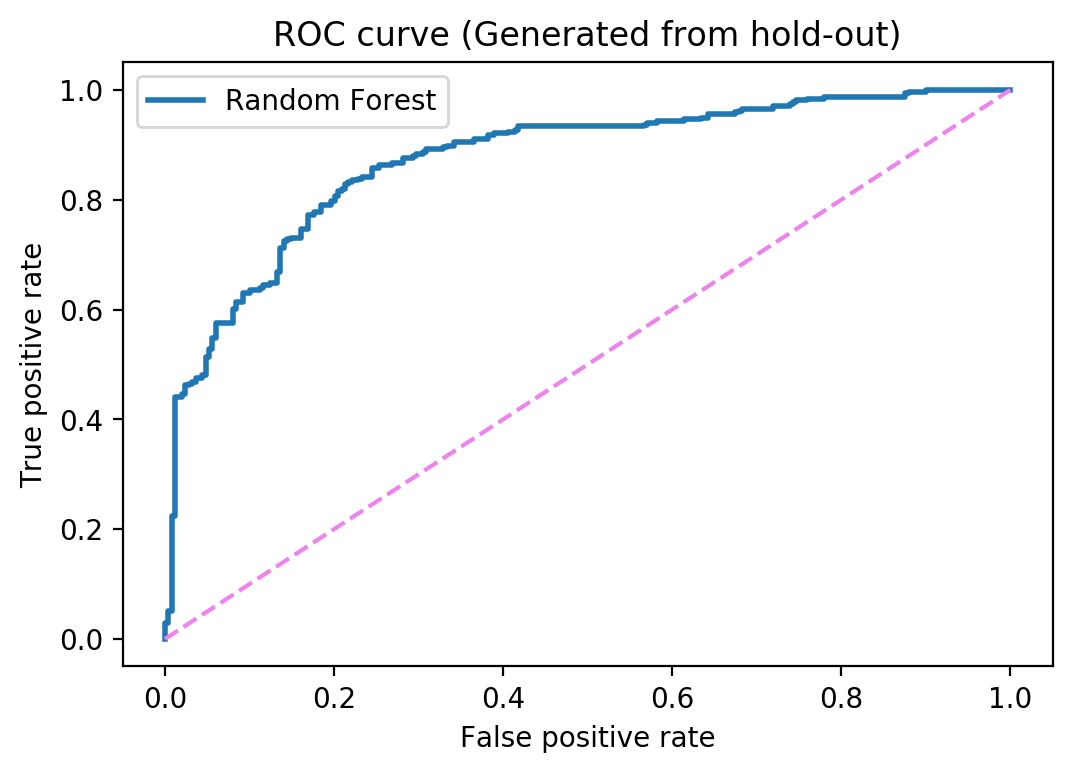

In [159]:
drugslib.rand_forestCV(X4,y4)

# Final Model

## Load Data

In [160]:
data_final = pd.read_csv('drugs_all_data_00.csv', index_col=0)

In [161]:
data_final.head()

,age,gender,education_level,country,ethnicity,neuroticism,extraversion,openness_to_experience,agreeableness,conscientiousness,...,Mixed-White/Asian,Other_Ethnicity,White,index,Canada,Ireland,New Zealand,Other_Country,United Kingdom,United States
0,35.0,0.0,20.0,United Kingdom,Mixed-White/Asian,0.3129,-0.5755,-0.5833,-0.9170,-0.0066,...,1,0,0,0,0,0,0,0,1,0
1,25.0,1.0,27.0,United Kingdom,White,-0.6783,1.9389,1.4353,0.7610,-0.1428,...,0,0,1,1,0,0,0,0,1,0
2,35.0,1.0,20.0,United Kingdom,White,-0.4672,0.8052,-0.8473,-1.6209,-1.0145,...,0,0,1,2,0,0,0,0,1,0
3,18.0,0.0,23.0,United Kingdom,White,-0.1488,-0.8062,-0.0193,0.5904,0.5849,...,0,0,1,3,0,0,0,0,1,0
4,35.0,0.0,27.0,United Kingdom,White,0.7355,-1.6334,-0.4517,-0.3017,1.3061,...,0,0,1,4,0,0,0,0,1,0


## Feature Engineering

### Modifications from Iteration 01

In [162]:
# create education columns
data_final['edu_vs_exp'] = data_final['education_level']/data_final['edu_exp_yr']
data_final['edu_vs_mean'] = data_final['education_level']/data_final['edu_mean_yr']

In [163]:
# create column to represent % of expected life lived
data_final['age_vs_exp'] = data_final['age']/(np.where(data_final['gender']==0, data_final['female_life'], 
                                                                    data_final['male_life']))


### Modifications from Iteration 02

In [164]:
data_final['big5'] = ( ((data_final['gender']+1)**2) * (
    ( data_final['sensation_seeking'] + data_final['openness_to_experience'] + 
         data_final['neuroticism'] + data_final['impulsivity'] ) / 
    (data_final['conscientiousness'] + data_final['age'])
                ))

### Modifications from Iteration 03

In [165]:
drugslib.new_val_and_replace(data_final, 'neuroticism', neurot_score)

New neuroticism values:
 [39. 29. 31. 34. 43. 24. 42. 33. 26. 56. 28. 27. 19. 22. 41. 49. 32. 25.
 40. 51. 35. 36. 46. 44. 37. 47. 23. 30. 38. 18. 45. 17. 53. 50. 60. 21.
 54. 59. 48. 20. 55. 16. 57. 52. 58. 14. 15. 13. 12.]

Description:
 count    1882.0000
mean       35.9293
std         9.1408
min        12.0000
25%        29.0000
50%        36.0000
75%        42.0000
max        60.0000
Name: neuroticism, dtype: float64


,age,gender,education_level,country,ethnicity,neuroticism,extraversion,openness_to_experience,agreeableness,conscientiousness,...,Canada,Ireland,New Zealand,Other_Country,United Kingdom,United States,edu_vs_exp,edu_vs_mean,age_vs_exp,big5
0,35.0,0.0,20.0,United Kingdom,Mixed-White/Asian,39.0,-0.5755,-0.5833,-0.9170,-0.0066,...,0,0,0,0,1,0,1.2270,1.5038,0.4217,-0.0477
1,25.0,1.0,27.0,United Kingdom,White,29.0,1.9389,1.4353,0.7610,-0.1428,...,0,0,0,0,1,0,1.6564,2.0301,0.3145,-0.0273
2,35.0,1.0,20.0,United Kingdom,White,31.0,0.8052,-0.8473,-1.6209,-1.0145,...,0,0,0,0,1,0,1.2270,1.5038,0.4403,-0.2699
3,18.0,0.0,23.0,United Kingdom,White,34.0,-0.8062,-0.0193,0.5904,0.5849,...,0,0,0,0,1,0,1.4110,1.7293,0.2169,-0.1468
4,35.0,0.0,27.0,United Kingdom,White,43.0,-1.6334,-0.4517,-0.3017,1.3061,...,0,0,0,0,1,0,1.6564,2.0301,0.4217,-0.0041
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1877,18.0,0.0,19.0,United States,White,25.0,1.7409,1.8851,0.7610,-1.1379,...,0,0,0,0,0,1,1.1515,1.4394,0.2211,0.2072
1878,18.0,1.0,19.0,United States,White,33.0,1.7409,0.5833,0.7610,-1.5184,...,0,0,0,0,0,1,1.1515,1.4394,0.2359,0.4813
1879,25.0,0.0,21.0,United States,White,47.0,-1.3764,-1.2755,-1.7720,-1.3850,...,0,0,0,0,0,1,1.2727,1.5909,0.3071,-0.0059
1880,18.0,0.0,19.0,United States,White,45.0,-1.9217,0.2934,-1.6209,-2.5731,...,0,0,0,0,0,1,1.1515,1.4394,0.2211,0.2412


In [166]:
drugslib.new_val_and_replace(data_final, 'extraversion', escore_list)

New extraversion values:
 [36. 52. 45. 34. 28. 38. 32. 55. 40. 41. 49. 29. 31. 39. 27. 43. 33. 16.
 44. 37. 51. 42. 48. 46. 47. 35. 50. 30. 26. 58. 53. 54. 23. 22. 24. 19.
 20. 21. 25. 56. 59. 18.]

Description:
 count    1882.0000
mean       39.5701
std         6.7697
min        16.0000
25%        35.0000
50%        40.0000
75%        44.0000
max        59.0000
Name: extraversion, dtype: float64


,age,gender,education_level,country,ethnicity,neuroticism,extraversion,openness_to_experience,agreeableness,conscientiousness,...,Canada,Ireland,New Zealand,Other_Country,United Kingdom,United States,edu_vs_exp,edu_vs_mean,age_vs_exp,big5
0,35.0,0.0,20.0,United Kingdom,Mixed-White/Asian,39.0,36.0,-0.5833,-0.9170,-0.0066,...,0,0,0,0,1,0,1.2270,1.5038,0.4217,-0.0477
1,25.0,1.0,27.0,United Kingdom,White,29.0,52.0,1.4353,0.7610,-0.1428,...,0,0,0,0,1,0,1.6564,2.0301,0.3145,-0.0273
2,35.0,1.0,20.0,United Kingdom,White,31.0,45.0,-0.8473,-1.6209,-1.0145,...,0,0,0,0,1,0,1.2270,1.5038,0.4403,-0.2699
3,18.0,0.0,23.0,United Kingdom,White,34.0,34.0,-0.0193,0.5904,0.5849,...,0,0,0,0,1,0,1.4110,1.7293,0.2169,-0.1468
4,35.0,0.0,27.0,United Kingdom,White,43.0,28.0,-0.4517,-0.3017,1.3061,...,0,0,0,0,1,0,1.6564,2.0301,0.4217,-0.0041
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1877,18.0,0.0,19.0,United States,White,25.0,51.0,1.8851,0.7610,-1.1379,...,0,0,0,0,0,1,1.1515,1.4394,0.2211,0.2072
1878,18.0,1.0,19.0,United States,White,33.0,51.0,0.5833,0.7610,-1.5184,...,0,0,0,0,0,1,1.1515,1.4394,0.2359,0.4813
1879,25.0,0.0,21.0,United States,White,47.0,30.0,-1.2755,-1.7720,-1.3850,...,0,0,0,0,0,1,1.2727,1.5909,0.3071,-0.0059
1880,18.0,0.0,19.0,United States,White,45.0,26.0,0.2934,-1.6209,-2.5731,...,0,0,0,0,0,1,1.1515,1.4394,0.2211,0.2412


In [167]:
drugslib.new_val_and_replace(data_final, 'openness_to_experience', oscore)

New openness_to_experience values:
 [42. 55. 40. 46. 43. 35. 39. 36. 38. 47. 49. 34. 44. 45. 29. 51. 37. 54.
 24. 41. 52. 48. 28. 53. 32. 33. 26. 31. 50. 58. 30. 56. 57. 60. 59.]

Description:
 count    1882.0000
mean       45.7630
std         6.5805
min        24.0000
25%        41.0000
50%        46.0000
75%        51.0000
max        60.0000
Name: openness_to_experience, dtype: float64


,age,gender,education_level,country,ethnicity,neuroticism,extraversion,openness_to_experience,agreeableness,conscientiousness,...,Canada,Ireland,New Zealand,Other_Country,United Kingdom,United States,edu_vs_exp,edu_vs_mean,age_vs_exp,big5
0,35.0,0.0,20.0,United Kingdom,Mixed-White/Asian,39.0,36.0,42.0,-0.9170,-0.0066,...,0,0,0,0,1,0,1.2270,1.5038,0.4217,-0.0477
1,25.0,1.0,27.0,United Kingdom,White,29.0,52.0,55.0,0.7610,-0.1428,...,0,0,0,0,1,0,1.6564,2.0301,0.3145,-0.0273
2,35.0,1.0,20.0,United Kingdom,White,31.0,45.0,40.0,-1.6209,-1.0145,...,0,0,0,0,1,0,1.2270,1.5038,0.4403,-0.2699
3,18.0,0.0,23.0,United Kingdom,White,34.0,34.0,46.0,0.5904,0.5849,...,0,0,0,0,1,0,1.4110,1.7293,0.2169,-0.1468
4,35.0,0.0,27.0,United Kingdom,White,43.0,28.0,43.0,-0.3017,1.3061,...,0,0,0,0,1,0,1.6564,2.0301,0.4217,-0.0041
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1877,18.0,0.0,19.0,United States,White,25.0,51.0,57.0,0.7610,-1.1379,...,0,0,0,0,0,1,1.1515,1.4394,0.2211,0.2072
1878,18.0,1.0,19.0,United States,White,33.0,51.0,50.0,0.7610,-1.5184,...,0,0,0,0,0,1,1.1515,1.4394,0.2359,0.4813
1879,25.0,0.0,21.0,United States,White,47.0,30.0,37.0,-1.7720,-1.3850,...,0,0,0,0,0,1,1.2727,1.5909,0.3071,-0.0059
1880,18.0,0.0,19.0,United States,White,45.0,26.0,48.0,-1.6209,-2.5731,...,0,0,0,0,0,1,1.1515,1.4394,0.2211,0.2412


In [168]:
drugslib.new_val_and_replace(data_final, 'agreeableness', ascore)

New agreeableness values:
 [37. 48. 32. 47. 41. 55. 38. 30. 49. 39. 36. 45. 40. 53. 50. 43. 33. 46.
 51. 23. 44. 29. 54. 42. 35. 34. 52. 31. 57. 56. 27. 25. 28. 58. 26. 59.
 24. 18. 12. 16. 60.]

Description:
 count    1882.0000
mean       42.8640
std         6.4339
min        12.0000
25%        39.0000
50%        43.0000
75%        48.0000
max        60.0000
Name: agreeableness, dtype: float64


,age,gender,education_level,country,ethnicity,neuroticism,extraversion,openness_to_experience,agreeableness,conscientiousness,...,Canada,Ireland,New Zealand,Other_Country,United Kingdom,United States,edu_vs_exp,edu_vs_mean,age_vs_exp,big5
0,35.0,0.0,20.0,United Kingdom,Mixed-White/Asian,39.0,36.0,42.0,37.0,-0.0066,...,0,0,0,0,1,0,1.2270,1.5038,0.4217,-0.0477
1,25.0,1.0,27.0,United Kingdom,White,29.0,52.0,55.0,48.0,-0.1428,...,0,0,0,0,1,0,1.6564,2.0301,0.3145,-0.0273
2,35.0,1.0,20.0,United Kingdom,White,31.0,45.0,40.0,32.0,-1.0145,...,0,0,0,0,1,0,1.2270,1.5038,0.4403,-0.2699
3,18.0,0.0,23.0,United Kingdom,White,34.0,34.0,46.0,47.0,0.5849,...,0,0,0,0,1,0,1.4110,1.7293,0.2169,-0.1468
4,35.0,0.0,27.0,United Kingdom,White,43.0,28.0,43.0,41.0,1.3061,...,0,0,0,0,1,0,1.6564,2.0301,0.4217,-0.0041
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1877,18.0,0.0,19.0,United States,White,25.0,51.0,57.0,48.0,-1.1379,...,0,0,0,0,0,1,1.1515,1.4394,0.2211,0.2072
1878,18.0,1.0,19.0,United States,White,33.0,51.0,50.0,48.0,-1.5184,...,0,0,0,0,0,1,1.1515,1.4394,0.2359,0.4813
1879,25.0,0.0,21.0,United States,White,47.0,30.0,37.0,31.0,-1.3850,...,0,0,0,0,0,1,1.2727,1.5909,0.3071,-0.0059
1880,18.0,0.0,19.0,United States,White,45.0,26.0,48.0,32.0,-2.5731,...,0,0,0,0,0,1,1.1515,1.4394,0.2211,0.2412


In [169]:
drugslib.new_val_and_replace(data_final, 'conscientiousness', cscore)

New conscientiousness values:
 [42. 41. 34. 46. 50. 52. 48. 49. 43. 53. 38. 36. 59. 47. 31. 30. 33. 35.
 51. 25. 37. 45. 39. 44. 27. 40. 29. 54. 55. 32. 56. 20. 28. 26. 22. 24.
 23. 19. 17. 21. 57.]

Description:
 count    1882.0000
mean       41.4368
std         6.9586
min        17.0000
25%        37.0000
50%        42.0000
75%        46.0000
max        59.0000
Name: conscientiousness, dtype: float64


,age,gender,education_level,country,ethnicity,neuroticism,extraversion,openness_to_experience,agreeableness,conscientiousness,...,Canada,Ireland,New Zealand,Other_Country,United Kingdom,United States,edu_vs_exp,edu_vs_mean,age_vs_exp,big5
0,35.0,0.0,20.0,United Kingdom,Mixed-White/Asian,39.0,36.0,42.0,37.0,42.0,...,0,0,0,0,1,0,1.2270,1.5038,0.4217,-0.0477
1,25.0,1.0,27.0,United Kingdom,White,29.0,52.0,55.0,48.0,41.0,...,0,0,0,0,1,0,1.6564,2.0301,0.3145,-0.0273
2,35.0,1.0,20.0,United Kingdom,White,31.0,45.0,40.0,32.0,34.0,...,0,0,0,0,1,0,1.2270,1.5038,0.4403,-0.2699
3,18.0,0.0,23.0,United Kingdom,White,34.0,34.0,46.0,47.0,46.0,...,0,0,0,0,1,0,1.4110,1.7293,0.2169,-0.1468
4,35.0,0.0,27.0,United Kingdom,White,43.0,28.0,43.0,41.0,50.0,...,0,0,0,0,1,0,1.6564,2.0301,0.4217,-0.0041
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1877,18.0,0.0,19.0,United States,White,25.0,51.0,57.0,48.0,33.0,...,0,0,0,0,0,1,1.1515,1.4394,0.2211,0.2072
1878,18.0,1.0,19.0,United States,White,33.0,51.0,50.0,48.0,30.0,...,0,0,0,0,0,1,1.1515,1.4394,0.2359,0.4813
1879,25.0,0.0,21.0,United States,White,47.0,30.0,37.0,31.0,31.0,...,0,0,0,0,0,1,1.2727,1.5909,0.3071,-0.0059
1880,18.0,0.0,19.0,United States,White,45.0,26.0,48.0,32.0,22.0,...,0,0,0,0,0,1,1.1515,1.4394,0.2211,0.2412


### Modifications from Iteration 04

In [170]:
data_final['nes_c'] = ((((data_final['neuroticism']/data_final['neuroticism'].loc[(data_final['user']==0)].mean())) * (data_final['extraversion']) * 2*(data_final['sensation_seeking'])) - 85*((data_final['conscientiousness']/(data_final['conscientiousness'].loc[(data_final['user']==1)].mean()))**2))


In [171]:
data_final['n_ac'] = ( data_final['neuroticism'] /  
                    (data_final['conscientiousness'] * data_final['agreeableness'] )
                 )


In [172]:
data_final['no_'] = ( data_final['neuroticism'] * data_final['openness_to_experience']
                 )


In [173]:
data_final['gdp_educ'] = ( (data_final['gdp_pc'] ) /  
                    ((data_final['conscientiousness']))
                  )

## Save Full Dataset

In [174]:
data_final.to_csv('drugs_all_data_FINAL.csv')

## Defining Final Model Data

In [175]:
data_final.columns

Index(['age', 'gender', 'education_level', 'country', 'ethnicity',
       'neuroticism', 'extraversion', 'openness_to_experience',
       'agreeableness', 'conscientiousness', 'impulsivity',
       'sensation_seeking', 'amphetamines', 'amyl_nitrite', 'benxodiazepine',
       'cannabis', 'cocaine', 'crack', 'ecstacy', 'heroin', 'ketamine',
       'legal_highs', 'LSD', 'methadone', 'mushrooms', 'Semeron(placebo)',
       'volatile_substance_abuse', 'continent', 'divorce_rate', 'edu_exp_yr',
       'edu_mean_yr', 'gdp_pc', 'overall_life', 'female_life', 'male_life',
       '_25_64', '_25_34', '_35_44', '_45_54', '_55_64', 'user', 'Black',
       'Mixed-Black/Asian', 'Mixed-Black/White', 'Mixed-White/Asian',
       'Other_Ethnicity', 'White', 'index', 'Canada', 'Ireland', 'New Zealand',
       'Other_Country', 'United Kingdom', 'United States', 'edu_vs_exp',
       'edu_vs_mean', 'age_vs_exp', 'big5', 'nes_c', 'n_ac', 'no_',
       'gdp_educ'],
      dtype='object')

In [176]:
# drop drug columns
X_final = data_final.drop(columns = [
    'amphetamines',   
    'amyl_nitrite',   
    'benxodiazepine',  
    'cannabis',   
    'cocaine',   
    'crack',    
    'ecstacy',   
    'heroin',   
    'ketamine',  
    'legal_highs',   
    'LSD',   
    'methadone',   
    'mushrooms',   
    'Semeron(placebo)',  
    'volatile_substance_abuse',   
    'continent',   
    'divorce_rate',    
    'ethnicity',   
    'country',  
    '_25_64',  
    '_25_34',  
    '_35_44',  
    '_45_54',  
    '_55_64',
    'education_level',
    'edu_exp_yr',  
    'edu_mean_yr',  
    'overall_life',   
    'female_life',   
    'male_life',
    'index',
    'Canada',  
    'Ireland',  
    'New Zealand',  
    'Other_Country',  
    'United Kingdom',  
    'United States',
    'age', 
    'gender', 
    'extraversion',
    'openness_to_experience', 
    'gdp_pc', 
    'Black',
    'Mixed-Black/White', 
    'Other_Ethnicity', 
    'White', 
    'Mixed-Black/Asian', 
    'Mixed-White/Asian',
    'user', 
], axis = 1)

y_final = data_final.user

In [177]:
X_final.columns

Index(['neuroticism', 'agreeableness', 'conscientiousness', 'impulsivity',
       'sensation_seeking', 'edu_vs_exp', 'edu_vs_mean', 'age_vs_exp', 'big5',
       'nes_c', 'n_ac', 'no_', 'gdp_educ'],
      dtype='object')

## Split Data

In [178]:
X_trainf, X_testf, y_trainf, y_testf = train_test_split(X_final, y_final, test_size = 0.2, random_state = 9)


## Fit Final Model

In [179]:
rf_final = RandomForestClassifier(
                bootstrap = True,
                criterion= 'gini',
                max_depth=5,
                max_features= 'auto',
                max_leaf_nodes=None,
                min_impurity_decrease= 0.0,
                min_impurity_split=None,
                min_samples_leaf=4,
                min_samples_split= 2,
                min_weight_fraction_leaf= 0.0,
                n_estimators= 37,
                n_jobs= None,
                oob_score= True,
                random_state= 9,
                verbose= 0,
                warm_start= False
)

In [180]:
rf_final.fit(X_trainf, y_trainf)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=37,
                       n_jobs=None, oob_score=True, random_state=9, verbose=0,
                       warm_start=False)

## Feature Importances Final Model

In [181]:
feature_importances = pd.DataFrame(rf_final.feature_importances_,
                                       index = X_trainf.columns,
                                        columns=['importance']).sort_values('importance', ascending=False)
feature_importances

,importance
gdp_educ,0.2550
big5,0.1898
sensation_seeking,0.1243
nes_c,0.1073
edu_vs_exp,0.0895
age_vs_exp,0.0620
edu_vs_mean,0.0461
no_,0.0390
impulsivity,0.0204
conscientiousness,0.0199


## Accuracy Final Model

In [182]:
final_acc = rf_final.score(X_testf, y_testf)
print(f'Accuracy for Random Forest on hold-out data: {final_acc}')

Accuracy for Random Forest on hold-out data: 0.8222811671087533


## Recall Final Model

In [183]:
y_predf = rf_final.predict(X_testf)

In [184]:
final_recall = recall_score(y_testf, y_predf) # recall

## Precision Final Model

In [185]:
final_precision = precision_score(y_testf, y_predf) # precision

## F1 Final Model

In [186]:
final_f1 = f1_score(y_testf, y_predf) # f1

## Final AUC Curve

In [187]:
y_testf

1603    0
345     1
257     0
969     1
2       0
       ..
1824    1
767     1
131     0
1343    1
1231    1
Name: user, Length: 377, dtype: int64

In [188]:
y_pred_probaf = rf_final.predict_proba(X_final
                                      )

In [190]:
fpr_final, tpr_final, thresholds_final = roc_curve(y_final, y_pred_probaf[:,1]) 

Final AUC: 0.9123023489626176


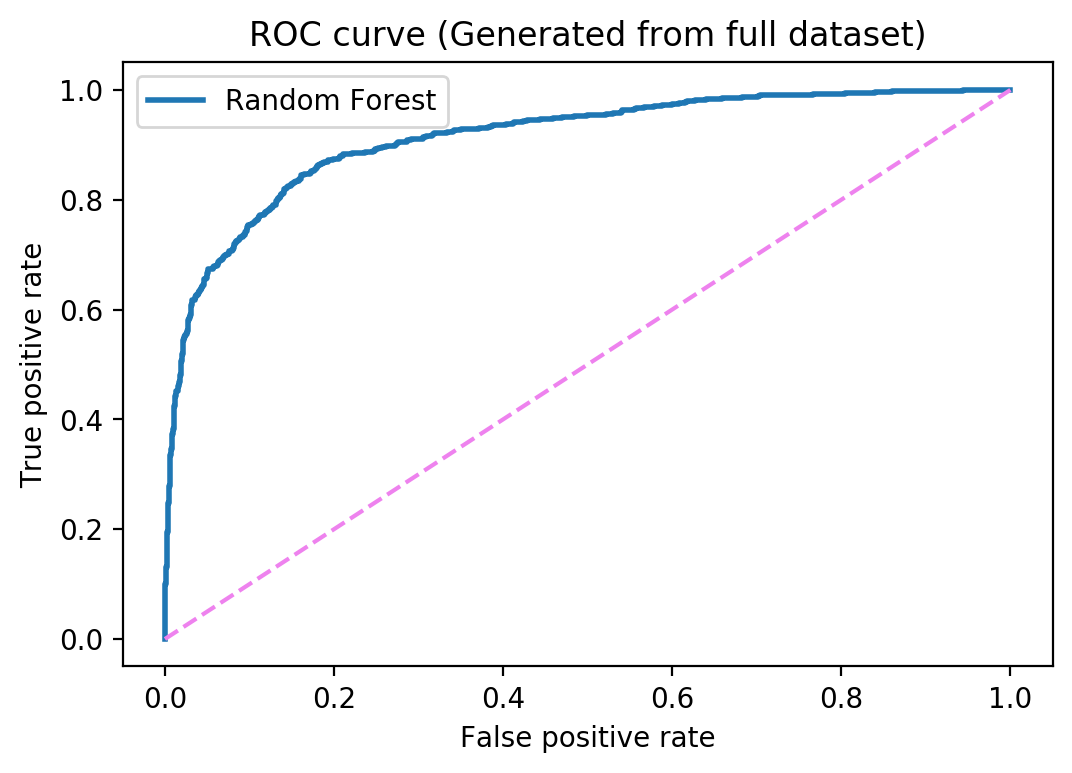

In [193]:
# plot ROC curve
plt.figure(dpi=200)
plt.plot(fpr_final, tpr_final,lw=2,label='Random Forest')
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title(f'ROC curve (Generated from full dataset)')
plt.legend()

# save ROC curve to png file
plt.savefig('ROC_CV_rf_FINAL.png')

final_auc = roc_auc_score(y_final, y_pred_probaf[:,1])
print(f'Final AUC: {final_auc}')
    

## Final Metrics

In [194]:
final_metrics = []
final_metrics.append(final_acc)
final_metrics.append(final_precision)
final_metrics.append(final_recall)
final_metrics.append(final_f1)
final_metrics.append(final_auc)

In [195]:
metrics_df = pd.DataFrame(final_metrics, columns = ['Metrics'], index = ['Accuracy',
                                                                         'Precision',
                                                                         'Recall',
                                                                         'f1',
                                                                         'AUC'])

In [196]:
metrics_df

,Metrics
Accuracy,0.8223
Precision,0.8333
Recall,0.8454
f1,0.8393
AUC,0.9123


## Final Confusion Matrix

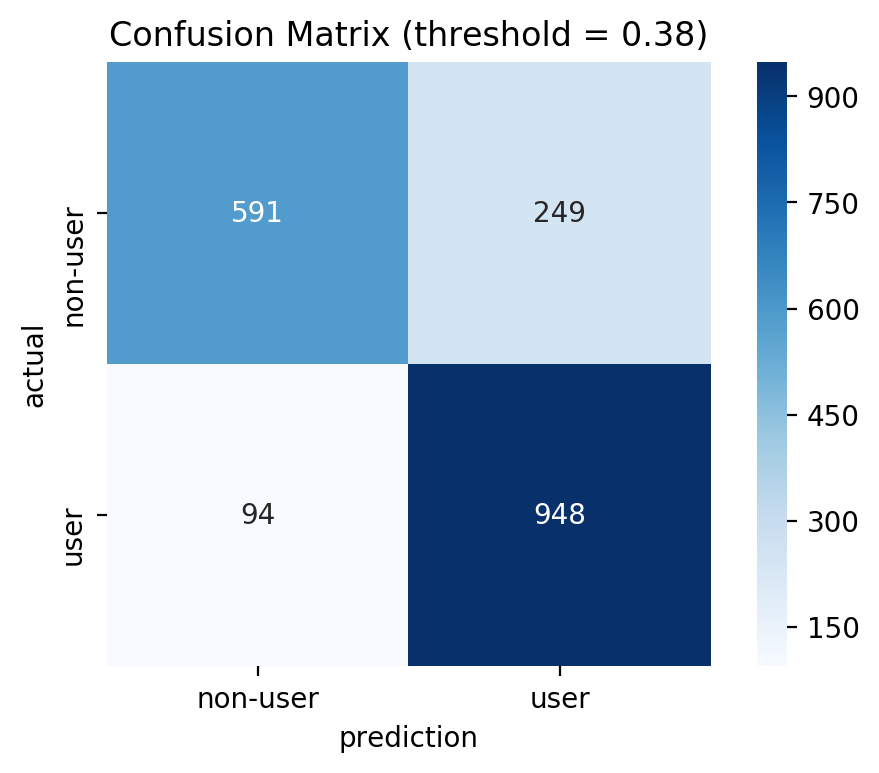

<Figure size 1440x1440 with 0 Axes>

In [198]:
drugs_confusion = confusion_matrix(y_final, (y_pred_probaf[:,1] >= 0.38))
    
    
plt.figure(dpi=200);
sns.heatmap(drugs_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
       xticklabels=['non-user', 'user'],
       yticklabels=['non-user', 'user']);
plt.title('Confusion Matrix (threshold = 0.38)')
plt.xlabel('prediction')
plt.ylabel('actual')
plt.figure(figsize = (20, 20));
plt.savefig('Confusion_CV_final.png');

## Precision and Recall Plot

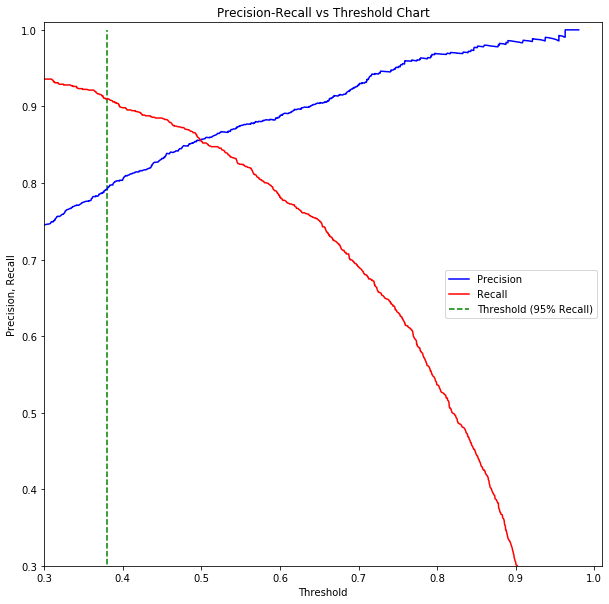

In [199]:

from sklearn.metrics import precision_recall_curve, auc
precision, recall, thresholds = precision_recall_curve(y_final, y_pred_probaf[:, 1]) 
pr_auc = auc(recall, precision)

fig, ax = plt.subplots(figsize = (10, 10))

# plt.figure(figsize = (10, 10))
plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b-", label="Precision")
ax.vlines(0.38, 0,1, 'g', linestyles = '--', label = 'Threshold (95% Recall)')
plt.plot(thresholds, recall[: -1], "r-", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="right")
plt.ylim([0.3,1.01])
plt.xlim([0.3,1.01])
plt.savefig('Precision_Recall_Final.png', dpi=300, transparent=True, bbox_inches='tight');

## Fit for Export

In [200]:
rf_fit_export = rf_final.fit(X_final, y_final)

In [201]:
pickle.dump(rf_fit_export, open('drugs_final_model.p',"wb"))

In [204]:
with open("drugs_final_model.p", "rb") as pfile:
    predictor = pickle.load(pfile)

In [205]:
data_final.loc[0,'user']

0

In [206]:
np.array(data_final.loc[0].drop(['country', 'ethnicity', 'continent']))

array([35.0, 0.0, 20.0, 39.0, 36.0, 42.0, 37.0, 42.0, -0.21712, -1.18084,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 40.91, 16.3, 13.3,
       39532.0, 81.2, 83.0, 79.5, 42.0, 49.0, 46.0, 38.0, 35.0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1.2269938650306749,
       1.5037593984962405, 0.42168674698795183, -0.04767763017830531,
       -193.25833699803755, 0.025096525096525095, 1638.0,
       941.2380952380952], dtype=object)

In [207]:
data_final.loc[0].drop(['country', 'ethnicity', 'continent'])

age                                35
gender                              0
education_level                    20
neuroticism                        39
extraversion                       36
openness_to_experience             42
agreeableness                      37
conscientiousness                  42
impulsivity                   -0.2171
sensation_seeking              -1.181
amphetamines                        0
amyl_nitrite                        0
benxodiazepine                      0
cannabis                            0
cocaine                             0
crack                               0
ecstacy                             0
heroin                              0
ketamine                            0
legal_highs                         0
LSD                                 0
methadone                           0
mushrooms                           0
Semeron(placebo)                    0
volatile_substance_abuse            0
divorce_rate                    40.91
edu_exp_yr  

In [208]:
check = predictor.predict_proba(np.array(data_final.loc[0].drop(['amphetamines',   
    'amyl_nitrite',   
    'benxodiazepine',  
    'cannabis',   
    'cocaine',   
    'crack',    
    'ecstacy',   
    'heroin',   
    'ketamine',  
    'legal_highs',   
    'LSD',   
    'methadone',   
    'mushrooms',   
    'Semeron(placebo)',  
    'volatile_substance_abuse',   
    'continent',   
    'divorce_rate',    
    'ethnicity',   
    'country',  
    '_25_64',  
    '_25_34',  
    '_35_44',  
    '_45_54',  
    '_55_64',
    'education_level',
    'edu_exp_yr',  
    'edu_mean_yr',  
    'overall_life',   
    'female_life',   
    'male_life',
    'index',
    'Canada',  
    'Ireland',  
    'New Zealand',  
    'Other_Country',  
    'United Kingdom',  
    'United States',
    'age', 
    'gender', 
    'extraversion',
    'openness_to_experience', 
    'gdp_pc', 
    'Black',
    'Mixed-Black/White', 
    'Other_Ethnicity', 
    'White', 
    'Mixed-Black/Asian', 
    'Mixed-White/Asian',
    'user',])).reshape(1, -1))

In [209]:
data_final.loc[0].drop(['amphetamines',   
    'amyl_nitrite',   
    'benxodiazepine',  
    'cannabis',   
    'cocaine',   
    'crack',    
    'ecstacy',   
    'heroin',   
    'ketamine',  
    'legal_highs',   
    'LSD',   
    'methadone',   
    'mushrooms',   
    'Semeron(placebo)',  
    'volatile_substance_abuse',   
    'continent',   
    'divorce_rate',    
    'ethnicity',   
    'country',  
    '_25_64',  
    '_25_34',  
    '_35_44',  
    '_45_54',  
    '_55_64',
    'education_level',
    'edu_exp_yr',  
    'edu_mean_yr',  
    'overall_life',   
    'female_life',   
    'male_life',
    'index',
    'Canada',  
    'Ireland',  
    'New Zealand',  
    'Other_Country',  
    'United Kingdom',  
    'United States',
    'age', 
    'gender', 
    'extraversion',
    'openness_to_experience', 
    'gdp_pc', 
    'Black',
    'Mixed-Black/White', 
    'Other_Ethnicity', 
    'White', 
    'Mixed-Black/Asian', 
    'Mixed-White/Asian',
    'user',])

neuroticism               39
agreeableness             37
conscientiousness         42
impulsivity          -0.2171
sensation_seeking     -1.181
edu_vs_exp             1.227
edu_vs_mean            1.504
age_vs_exp            0.4217
big5                -0.04768
nes_c                 -193.3
n_ac                  0.0251
no_                     1638
gdp_educ               941.2
Name: 0, dtype: object

In [210]:
check[0][1]

0.16135286415357372

# Flask App Reference Table

Table will contain expected and mean educational levels, gdp, life expectancy data by country which will be exported to a Flask App for reference.

In [211]:
# Merge Edu and GDP tables
ref_table = pd.merge(edu_df[['country', 'edu_exp_yr','edu_mean_yr']], 
                     gdp_df[['country','gdp_pc']], 
                     how = 'left', 
                     on = 'country' 
                    )

In [212]:
# Merge in life table
ref_table = pd.merge(ref_table, 
                     life_df[['country','female_life','male_life']], 
                     how = 'left', 
                     on = 'country' 
                    )
ref_table

,country,edu_exp_yr,edu_mean_yr,gdp_pc,female_life,male_life
0,Australia,20.4,13.2,53831.0,85.3,81.3
1,Denmark,19.2,12.7,57545.0,82.8,77.8
2,New Zealand,19.2,12.5,43415.0,83.9,80.4
3,Norway,17.7,12.7,75428.0,84.3,80.3
4,Germany,17.1,13.2,44680.0,83.6,78.8
...,...,...,...,...,...,...
183,South Sudan,4.9,4.8,NaN,59.1,56.1
184,Chad,7.3,2.3,657.0,55.4,52.6
185,Eritrea,5.0,3.9,NaN,68.2,63.8
186,Burkina Faso,7.7,1.4,642.0,61.9,60.4


## Save to CSV

In [213]:
ref_table.to_csv('ref_table.csv')

In [214]:
# Verify save
ref_check = pd.read_csv('ref_table.csv', index_col = 0)
ref_check

,country,edu_exp_yr,edu_mean_yr,gdp_pc,female_life,male_life
0,Australia,20.4,13.2,53831.0,85.3,81.3
1,Denmark,19.2,12.7,57545.0,82.8,77.8
2,New Zealand,19.2,12.5,43415.0,83.9,80.4
3,Norway,17.7,12.7,75428.0,84.3,80.3
4,Germany,17.1,13.2,44680.0,83.6,78.8
...,...,...,...,...,...,...
183,South Sudan,4.9,4.8,NaN,59.1,56.1
184,Chad,7.3,2.3,657.0,55.4,52.6
185,Eritrea,5.0,3.9,NaN,68.2,63.8
186,Burkina Faso,7.7,1.4,642.0,61.9,60.4


# Bagging - Evaluation of estimators on Variance

In [ ]:
# Run bagging classifier through cross validation
# ~45s to run
# instructor: pull up the bagging classifier docs if useful
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html

variance = []
bias = []
test_range = np.arange(10, 150, 10)

for i in test_range:
    cv_out = cross_validate(
        estimator=BaggingRegressor(
            RandomForestClassifier(random_state=9), n_estimators=i), # determine number of estimators to bag
        X=X4,
        y=y4,
        cv=5,
        return_train_score=True,
        scoring={
            "variance": make_scorer(drugslib.variance_metric),
            "bias": make_scorer(drugslib.bias_metric)
        },
        n_jobs=-1,
    )
    variance.append(np.mean(cv_out['test_variance']))
    bias.append(np.mean(cv_out['test_bias']))

In [ ]:
plt.figure(dpi=150)
plt.plot(test_range, variance, label='variance')
plt.ylim((0, 0.65))
plt.xlabel('Number of Estimators')
plt.ylabel('Variance Score');
plt.title('Variance Score vs No. of Estimators');

plt.figure(dpi=150)
plt.plot(test_range, bias, label='bias', c='r')
plt.ylim((1.3, 1.4))
plt.xlabel('Number of Estimators')
plt.ylabel('Bias Score');
plt.title('Bias Score vs No. of Estimators');

# Stacking Code

In [ ]:
stacked = StackingClassifier(estimators = RandomForestClassifier(
            bootstrap = True,
                
                criterion= 'gini',
                max_depth=5,
                max_features= 'auto',
                max_leaf_nodes=None,
                min_impurity_decrease= 0.0,
                min_impurity_split=None,
                min_samples_leaf=4,
                min_samples_split= 2,
                min_weight_fraction_leaf= 0.0,
                n_estimators= 900,
                n_jobs= None,
                oob_score= True,
                random_state= 9,
                verbose= 0,
                warm_start= True
    ), final_estimator = LogisticRegression())

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X4, y4, stratify = y4, random_state=9)

In [ ]:
stacked.fit(X_train, y_train)

In [ ]:
# Plot model
plot_decision_regions(X_train.values, y_train.values, stacked)
plt.title('Stacked classifier')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.gcf().set_size_inches(12,8)

In [ ]:
y_pred = stacked.predict(X_test)
accuracy_score(y_test, y_pred)

# Drug Reference Info

Amphetamines: https://www.dea.gov/factsheets/amphetamines
- ADHD medication (Adderall, Ritalin, etc)
- aka 'Bennies, black beauties, crank, ice, speed, uppers'
- crystal meth

Amyl Nitrite: https://en.wikipedia.org/wiki/Amyl_nitrite  
- treatment for heart disease, antidote for cyanide poisoning
- recreational inhalant (poppers)
  
Benxodiazepine: https://en.wikipedia.org/wiki/Benzodiazepine#Recreational_use 
- 'benzos'
- minor tranquilizers

Ketamine: https://en.wikipedia.org/wiki/Ketamine  

Methadone: https://www.drugs.com/methadone.html  

The Five Factor Model of Personality
https://www.oxfordbibliographies.com/view/document/obo-9780199828340/obo-9780199828340-0120.xml